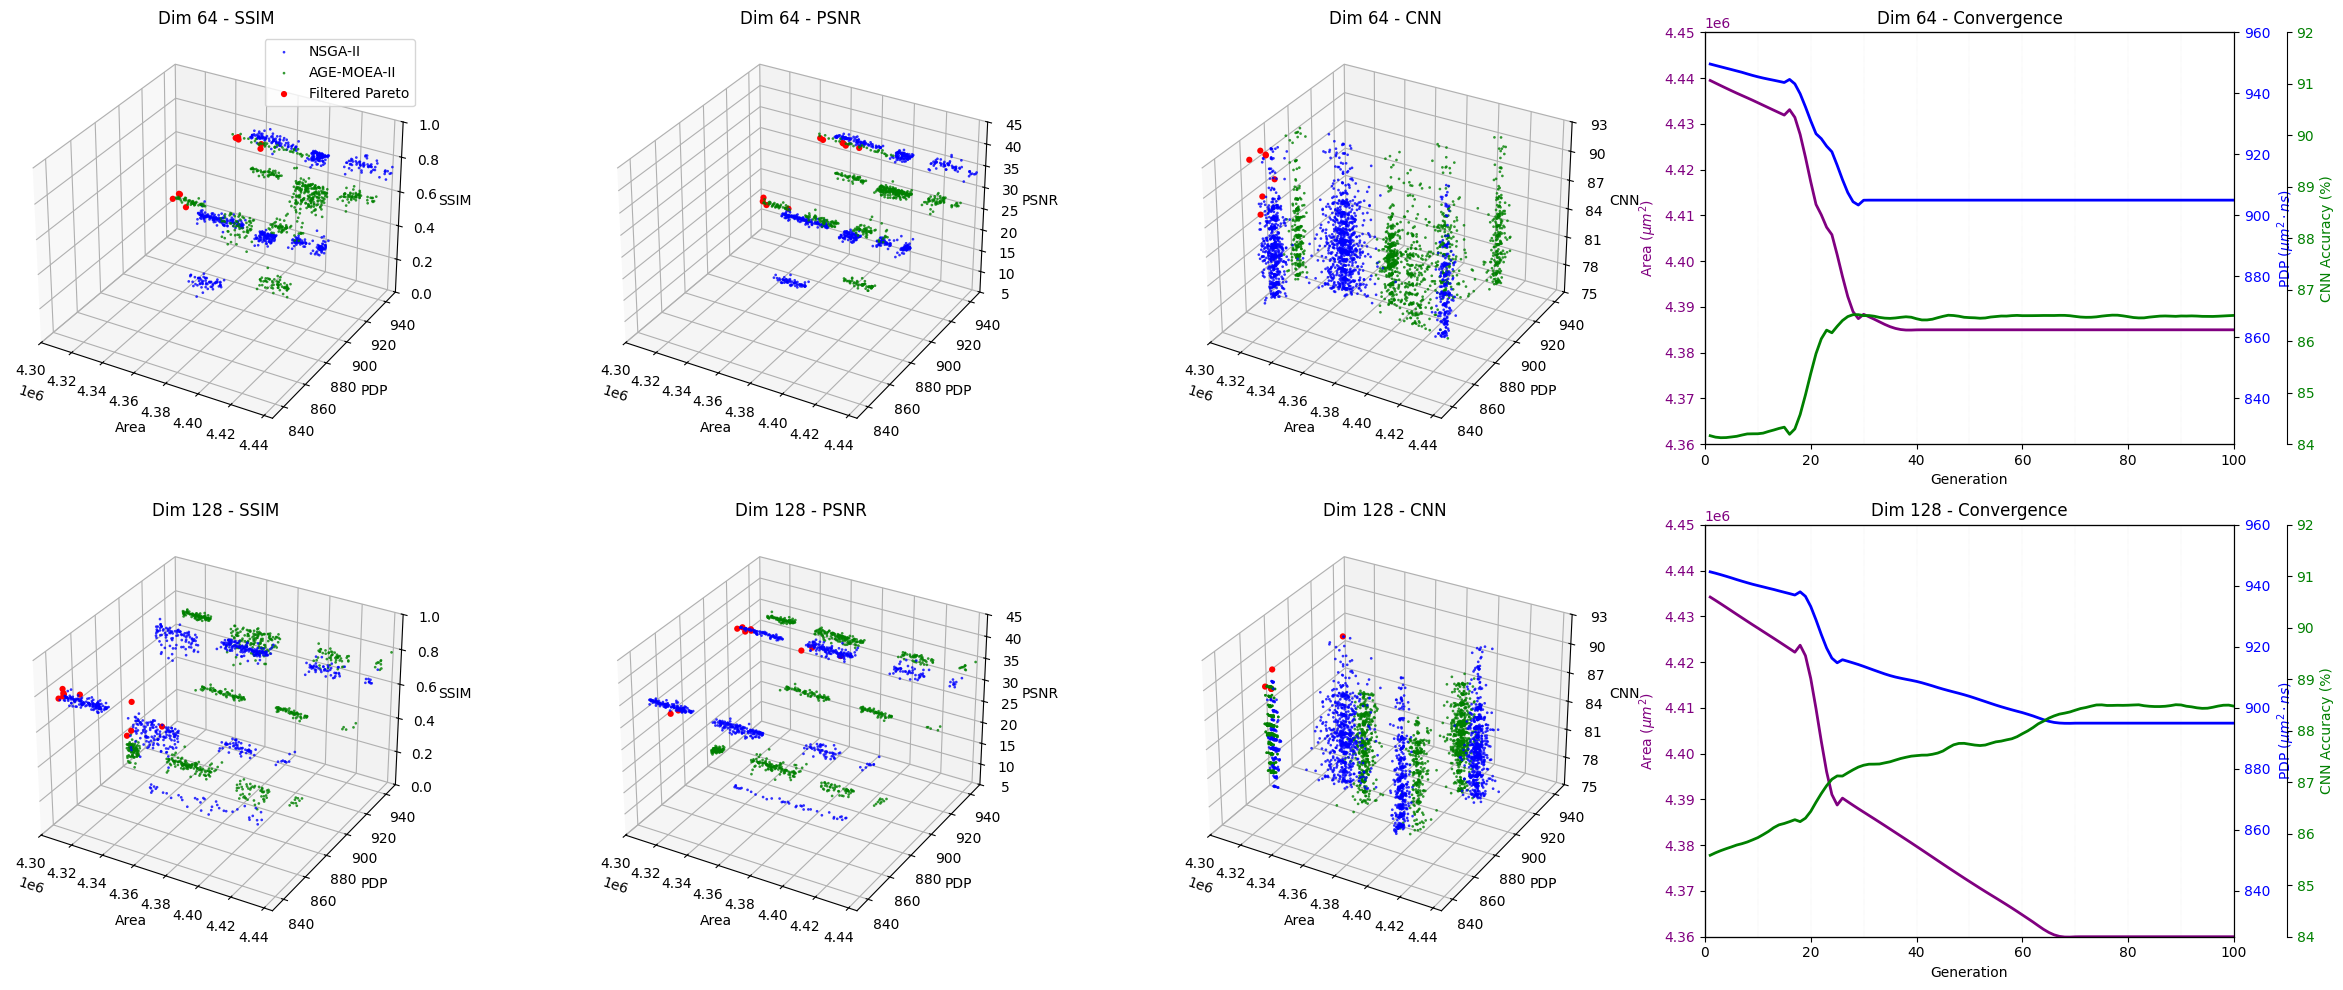

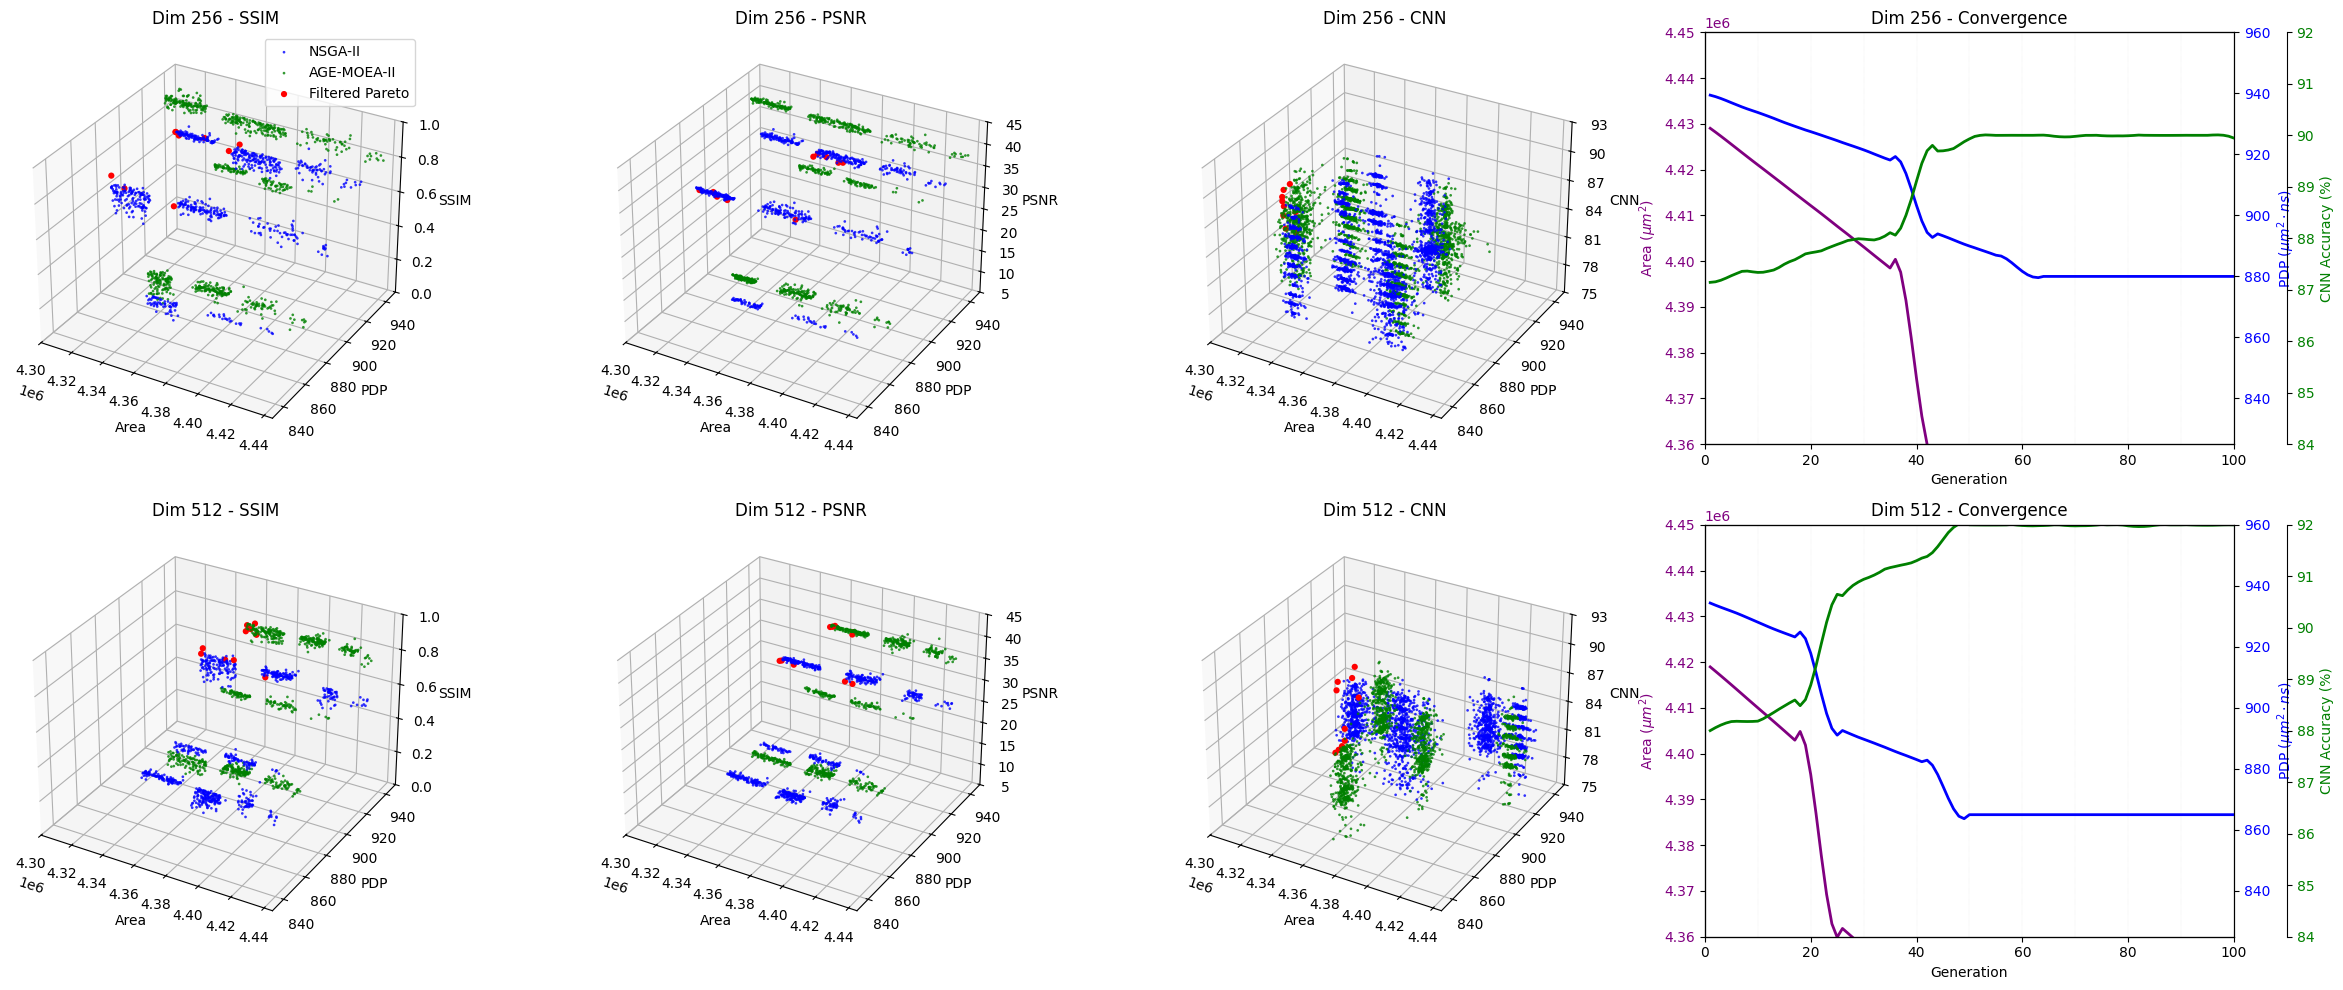

✅ All individual plots and CSVs saved in 'individuals' folder.
✅ Combined plots saved as 'final_plot_64_128.png' and 'final_plot_256_512.png'.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.signal import savgol_filter
import os

os.makedirs('individuals', exist_ok=True)

# ---------------- Threshold Filter Functions ----------------
def filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['SSIM'] >= z_thresh)
    ]

def filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['PSNR'] >= z_thresh)
    ]

def filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['CNN'] >= z_thresh)
    ]

# ---------------- Pareto Computation ----------------
def find_pareto_front(data, metric_col, maximize_metric=True):
    def is_dominated(p1, p2):
        a1, d1, m1 = p1['Area'], p1['PDP'], p1[metric_col]
        a2, d2, m2 = p2['Area'], p2['PDP'], p2[metric_col]

        if maximize_metric:
            better_eq = a2 <= a1 and d2 <= d1 and m2 >= m1
            strict = a2 < a1 or d2 < d1 or m2 > m1
        else:
            better_eq = a2 <= a1 and d2 <= d1 and m2 <= m1
            strict = a2 < a1 or d2 < d1 or m2 < m1

        return better_eq and strict

    pareto_front = []
    for p1 in data:
        if not any(is_dominated(p1, p2) for p2 in data if p2 != p1):
            pareto_front.append(p1)
    return pareto_front

# ---------------- Generate Convergence Data ----------------
CONVERGENCE_CONFIGS = {
    64:   {'Area': (4440000, 4385000), 'PDP': (950, 905), 'Accuracy': (84, 86.5)},
    128:  {'Area': (4435000, 4360000), 'PDP': (945, 895), 'Accuracy': (85.5, 88.5)},
    256:  {'Area': (4430000, 4340000), 'PDP': (940, 880), 'Accuracy': (87, 90)},
    512:  {'Area': (4420000, 4320000), 'PDP': (935, 865), 'Accuracy': (88, 92)},
}

def generate_convergence_data():
    np.random.seed(42)
    generations = 100
    latent_dims = [64, 128, 256, 512]
    results = {}
    window = 9 if generations >= 11 else generations // 2 * 2 + 1
    poly_order = 3

    for dim in latent_dims:
        cfg = CONVERGENCE_CONFIGS[dim]
        start_area, end_area = cfg['Area']
        start_pdp, end_pdp = cfg['PDP']
        start_acc, end_acc = cfg['Accuracy']

        retrain_indices = sorted(np.random.choice(np.arange(15, generations - 10), size=3, replace=False))

        area, pdp, acc = [], [], []
        cur_area, cur_pdp, cur_acc = start_area, start_pdp, start_acc

        area_step = (end_area - start_area) / generations
        pdp_step = (end_pdp - start_pdp) / generations
        acc_step = (end_acc - start_acc) / generations

        retrain_area_boost = (end_area - start_area) / len(retrain_indices)
        retrain_pdp_boost = (end_pdp - start_pdp) / len(retrain_indices)
        retrain_acc_boost = (end_acc - start_acc) / len(retrain_indices)

        for gen in range(generations):
            # Add occasional retraining-induced jumps
            if gen in retrain_indices:
                cur_area += retrain_area_boost + np.random.normal(0, 1000)
                cur_pdp += retrain_pdp_boost + np.random.normal(0, 1.0)
                cur_acc += retrain_acc_boost + np.random.normal(0, 0.3)

            # Add smooth progression
            cur_area += area_step + np.random.normal(0, 30)
            cur_pdp += pdp_step + np.random.normal(0, 0.1)
            cur_acc += acc_step + np.random.normal(0, 0.05)

            # Clip within bounds
            cur_area = np.clip(cur_area, end_area, start_area)
            cur_pdp = np.clip(cur_pdp, end_pdp, start_pdp)
            cur_acc = np.clip(cur_acc, start_acc, end_acc)

            area.append(cur_area)
            pdp.append(cur_pdp)
            acc.append(cur_acc)

        # Smooth curves after jump modeling
        smooth_area = savgol_filter(area, window, poly_order)
        smooth_pdp = savgol_filter(pdp, window, poly_order)
        smooth_acc = savgol_filter(acc, window, poly_order)

        results[dim] = {
            'Area': smooth_area,
            'PDP': smooth_pdp,
            'Accuracy': smooth_acc
        }

        df = pd.DataFrame({
            'generation_no': np.arange(1, generations + 1),
            'PDP': smooth_pdp,
            'Area': smooth_area,
            'Accuracy': smooth_acc
        })
        df.to_csv(f'individuals/vae_convergence_{dim}.csv', index=False)

    return results, np.arange(1, generations + 1)



# def generate_convergence_data():
#     np.random.seed(42)
#     generations = 100
#     retrain_interval = 10
#     latent_dims = [64, 128, 256, 512]
#     results = {}
#     window = 9 if generations >= 11 else generations // 2 * 2 + 1  # Savitzky-Golay window
#     poly_order = 3


#     for dim in latent_dims:
#         np.random.seed(42 + dim)
#         base_area = 4440000 - (dim * 4)
#         base_pdp = 950 - (dim / 128) * 10
#         base_acc = 84 + (dim / 128) * 2

#         area, pdp, acc = [], [], []
#         cur_area, cur_pdp, cur_acc = base_area, base_pdp, base_acc

#         for gen in range(1, generations + 1):
#             if gen % retrain_interval == 0:
#                 retrain_noise = np.random.normal(0, 2000)
#                 retrain_pdp_shift = np.random.normal(0, 1.5)
#                 retrain_acc_boost = np.random.normal(0.2, 0.3)

#                 if np.random.rand() < 0.3:
#                     retrain_noise -= 1500
#                     retrain_pdp_shift -= 0.8
#                     retrain_acc_boost += 0.8

#                 cur_area += retrain_noise
#                 cur_area = max(cur_area, 4300000)
#                 cur_pdp += retrain_pdp_shift
#                 cur_pdp = max(cur_pdp, 820)
#                 cur_acc += retrain_acc_boost
#                 cur_acc = min(cur_acc, 92)

#             cur_area += np.random.normal(-5, 50)
#             cur_pdp += np.random.normal(-0.01, 0.2)
#             cur_acc += np.random.normal(0.01, 0.05)

#             cur_area = np.clip(cur_area, 4300000, 4470000)
#             cur_pdp = np.clip(cur_pdp, 820, 970)
#             cur_acc = np.clip(cur_acc, 84, 92)

#             area.append(cur_area)
#             pdp.append(cur_pdp)
#             acc.append(cur_acc)

#         # Apply savgol_filter for smooth base curves
#         smooth_area = savgol_filter(area, window, poly_order)
#         smooth_pdp = savgol_filter(pdp, window, poly_order)
#         smooth_acc = savgol_filter(acc, window, poly_order)

#         # Inject retraining spikes at retrain intervals
#         for gen in range(retrain_interval - 1, generations, retrain_interval):
#             spike_scale = max(1.0, 512 / dim)  # Smaller for large dim
#             smooth_area[gen] += np.random.normal(8000, 2000) / spike_scale
#             smooth_pdp[gen] += np.random.normal(2.5, 0.5) / spike_scale
#             smooth_acc[gen] += np.random.normal(0.5, 0.2) / spike_scale

#         # Clip to keep within bounds
#         smooth_area = np.clip(smooth_area, 4300000, 4470000)
#         smooth_pdp = np.clip(smooth_pdp, 820, 970)
#         smooth_acc = np.clip(smooth_acc, 84, 92)
#         results[dim] = {
#             'Area': smooth_area,
#             'PDP': smooth_pdp,
#             'Accuracy': smooth_acc
#         }

#         # Save to CSV
#         df = pd.DataFrame({
#             'generation_no': np.arange(1, generations + 1),
#             'PDP': smooth_pdp,
#             'Area': smooth_area,
#             'Accuracy': smooth_acc
#         })
#         df.to_csv(f'individuals/vae_convergence_{dim}.csv', index=False)

#     return results, np.arange(1, generations + 1)


# ---------------- Configuration ----------------
dimensions = [64, 128, 256, 512]
folder_mapping = {
    'SSIM': 'all_4_dim_vae_plots_ssim',
    'PSNR': 'all_4_dim_vae_plots_psnr',
    'CNN': 'all_4_dim_vae_plots_cnn'
}

# Legend and color mapping
label_legend_map = {
    'set1': 'NSGA-II',
    'set2': 'AGE-MOEA-II'
}
color_map = {'set1': 'blue', 'set2': 'green'}
common_marker = '.'

# Thresholds
x_thresh = 4380000
y_thresh = 930
thresholds = {'SSIM': 0.6, 'PSNR': 25, 'CNN': 87}

# Generate convergence data
convergence_results, generations_x = generate_convergence_data()

# ---------------- Process Each Metric and Generate Individual Plots ----------------
def process_metric_and_save(metric, dim, folder_path):
    """Process a single metric for a given dimension and save individual plot and CSV"""
    
    # Determine CSV filename based on metric
    if metric == 'PSNR':
        csv_file = f"generated_{dim}_psnr.csv"
    else:
        csv_file = f"generated_{dim}.csv"
    
    csv_path = os.path.join(folder_path, csv_file)
    
    if not os.path.exists(csv_path):
        print(f"Warning: {csv_path} not found. Skipping {metric} for dim {dim}")
        return None, None
    
    # Load data
    df = pd.read_csv(csv_path)
    filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
    data_list = filtered_df[['Area', 'PDP', metric]].to_dict('records')

    # Add index for traceability
    for j, row in enumerate(data_list):
        row['index'] = filtered_df.index[j]

    # Find Pareto front
    pareto_points = find_pareto_front(data_list, metric, maximize_metric=True)
    pareto_indices = [p['index'] for p in pareto_points]
    pareto_df = df.loc[pareto_indices]

    # Filter Pareto points by threshold
    if metric == 'SSIM':
        filtered_pareto = filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, thresholds[metric])
    elif metric == 'PSNR':
        filtered_pareto = filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, thresholds[metric])
    else:  # CNN
        filtered_pareto = filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, thresholds[metric])
    
    if len(filtered_pareto) > 10:
        filtered_pareto = filtered_pareto.sample(n=10, random_state=42)

    # Save filtered Pareto to CSV
    output_csv = f'individuals/CSV_pareto_{dim}_{metric.lower()}.csv'
    filtered_pareto.to_csv(output_csv, index=False)

    # Create individual plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter all points by label
    for label, color in color_map.items():
        subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
        ax.scatter(subset['Area'], subset['PDP'], subset[metric],
                   c=color, marker=common_marker, s=15,
                   label=label_legend_map[label],
                   alpha=0.8, edgecolor='none')

    # Plot filtered Pareto points
    ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto[metric],
               c='red', marker='o', s=20, label='Filtered Pareto',
               alpha=1.0, edgecolors='none')

    # Set axes limits and labels based on metric
    ax.set_xlim(4300000, 4445000)
    ax.set_ylim(830, 950)
    
    if metric == 'SSIM':
        ax.set_zlim(0, 1)
        ax.set_zticks([round(i * 0.2, 2) for i in range(6)])
    elif metric == 'PSNR':
        ax.set_zlim(5, 45)
        ax.set_zticks(list(range(5, 50, 5)))
    else:  # CNN
        ax.set_zlim(75, 93)
        ax.set_zticks(list(range(75, 94, 3)))
    
    ax.set_xlabel('Area')
    ax.set_ylabel('PDP')
    ax.set_zlabel(metric)
    ax.set_title(f'3D Plot: Dim {dim} - {metric}')
    ax.legend()

    # Save individual plot
    output_plot = f'individuals/plot_{dim}_{metric.lower()}.png'
    plt.tight_layout()
    plt.savefig(output_plot, dpi=700, bbox_inches='tight')
    plt.close()

    return ax, filtered_pareto

# ---------------- Create Combined 2x4 Subplot Figures ----------------
def create_combined_plots():
    # Create two main plots: 64-128 and 256-512
    dim_groups = [(64, 128), (256, 512)]
    
    for group_idx, (dim1, dim2) in enumerate(dim_groups):
        # fig, axes = plt.subplots(2, 4, figsize=(20, 12), subplot_kw={'projection': '3d'})
        fig, axes = plt.subplots(2, 4, figsize=(24, 10), subplot_kw={'projection': '3d'})
        fig.align_ylabels()  # Aligns y-axis labels across rows

        
        # Process each row (dimension) and column (metric)
        for row_idx, dim in enumerate([dim1, dim2]):
            col_idx = 0
            
            # SSIM column
            folder_path = folder_mapping['SSIM']
            csv_file = f"generated_{dim}.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'SSIM']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'SSIM', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, thresholds['SSIM'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['SSIM'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['SSIM'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(4300000, 4445000)
                ax.set_ylim(830, 950)
                ax.set_zlim(0, 1)
                ax.set_zticks([round(i * 0.2, 2) for i in range(6)])
                ax.set_xlabel('Area')
                ax.set_ylabel('PDP')
                ax.set_zlabel('SSIM')
                ax.set_title(f'Dim {dim} - SSIM')
                if row_idx == 0 and col_idx == 0:
                    ax.legend()
            
            col_idx += 1
            
            # PSNR column
            folder_path = folder_mapping['PSNR']
            csv_file = f"generated_{dim}_psnr.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'PSNR']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'PSNR', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, thresholds['PSNR'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['PSNR'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['PSNR'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(4300000, 4445000)
                ax.set_ylim(830, 950)
                ax.set_zlim(5, 45)
                ax.set_zticks(list(range(5, 50, 5)))
                ax.set_xlabel('Area')
                ax.set_ylabel('PDP')
                ax.set_zlabel('PSNR')
                ax.set_title(f'Dim {dim} - PSNR')
            
            col_idx += 1
            
            # CNN column
            folder_path = folder_mapping['CNN']
            csv_file = f"generated_{dim}.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'CNN']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'CNN', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, thresholds['CNN'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['CNN'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['CNN'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(4300000, 4445000)
                ax.set_ylim(830, 950)
                ax.set_zlim(75, 93)
                ax.set_zticks(list(range(75, 94, 3)))
                ax.set_xlabel('Area')
                ax.set_ylabel('PDP')
                ax.set_zlabel('CNN')
                ax.set_title(f'Dim {dim} - CNN')
            
            col_idx += 1
            
            # Convergence column
            # ax = axes[row_idx, col_idx]
            # # Remove 3D projection for convergence plot
            # ax.remove()
            # ax = fig.add_subplot(2, 4, row_idx*4 + col_idx + 1)
            
            # ax2 = ax.twinx()
            # ax3 = ax.twinx()
            # ax3.spines['right'].set_position(('axes', 1.1))
            
            # ax.plot(generations_x, convergence_results[dim]['Area'], 'purple', label='Area', linewidth=2)
            # ax.set_ylabel('Area ($\mu m^2$)', color='purple')
            # ax.tick_params(axis='y', labelcolor='purple')
            # ax.set_ylim(4360000, 4470000)
            
            # ax2.plot(generations_x, convergence_results[dim]['PDP'], 'blue', label='PDP', linewidth=2)
            # ax2.set_ylabel('PDP ($\mu m^2 \cdot ns$)', color='blue')
            # ax2.tick_params(axis='y', labelcolor='blue')
            # ax2.set_ylim(825, 980)
            
            # ax3.plot(generations_x, convergence_results[dim]['Accuracy'], 'green', label='Accuracy', linewidth=2)
            # ax3.set_ylabel('CNN Accuracy (%)', color='green')
            # ax3.tick_params(axis='y', labelcolor='green')
            # ax3.set_ylim(84, 95)
            
            # ax.set_title(f'Dim {dim} - Convergence')
            # # Overlay retraining vertical lines
            # for g in range(10, len(generations_x)+1, 10):
            #     ax.axvline(x=g, color='gray', linestyle='--', linewidth=0.5, alpha=0.4)
            # ax.set_xlabel('Generation')

            # Convergence column
            ax = axes[row_idx, col_idx]
            # Remove 3D projection for convergence plot
            ax.remove()
            ax = fig.add_subplot(2, 4, row_idx*4 + col_idx + 1)

            ax2 = ax.twinx()
            ax3 = ax.twinx()
            ax3.spines['right'].set_position(('axes', 1.15))

            # Plot with reference-style ranges
            ax.plot(generations_x, convergence_results[dim]['Area'], 'purple', label='Area', linewidth=2)
            ax.set_ylabel('Area ($\mu m^2$)', color='purple')
            ax.tick_params(axis='y', labelcolor='purple')
            ax.set_ylim(4360000, 4450000)  # Adjusted to reference range

            ax2.plot(generations_x, convergence_results[dim]['PDP'], 'blue', label='PDP', linewidth=2)
            ax2.set_ylabel('PDP ($\mu m^2 \cdot ns$)', color='blue')
            ax2.tick_params(axis='y', labelcolor='blue')
            ax2.set_ylim(825, 960)  # Adjusted to reference range

            ax3.plot(generations_x, convergence_results[dim]['Accuracy'], 'green', label='Accuracy', linewidth=2)
            ax3.set_ylabel('CNN Accuracy (%)', color='green')
            ax3.tick_params(axis='y', labelcolor='green')
            ax3.set_ylim(84, 92)  # Adjusted to reference range

            ax.set_title(f'Dim {dim} - Convergence')
            ax.set_xlabel('Generation')
            ax.set_xlim(0, len(generations_x))  # Ensure full x-range

            # Retraining lines (more subtle)
            for g in range(10, len(generations_x)+1, 10):
                ax.axvline(x=g, color='gray', linestyle=':', linewidth=0.3, alpha=0.3)
                    
        # Save combined plot
        plt.tight_layout()
        # plt.subplots_adjust(wspace=0.4)  # Adjust these values slightly if needed
        
        if group_idx == 0:
            plt.savefig('final_plot_64_128.png', dpi=700, bbox_inches='tight')
        else:
            plt.savefig('final_plot_256_512.png', dpi=700, bbox_inches='tight')
        plt.show()
        plt.close()

# Process individual metrics and save individual plots and CSVs
for metric, folder in folder_mapping.items():
    for dim in dimensions:
        process_metric_and_save(metric, dim, folder)

# Create combined plots
create_combined_plots()

print("✅ All individual plots and CSVs saved in 'individuals' folder.")
print("✅ Combined plots saved as 'final_plot_64_128.png' and 'final_plot_256_512.png'.")

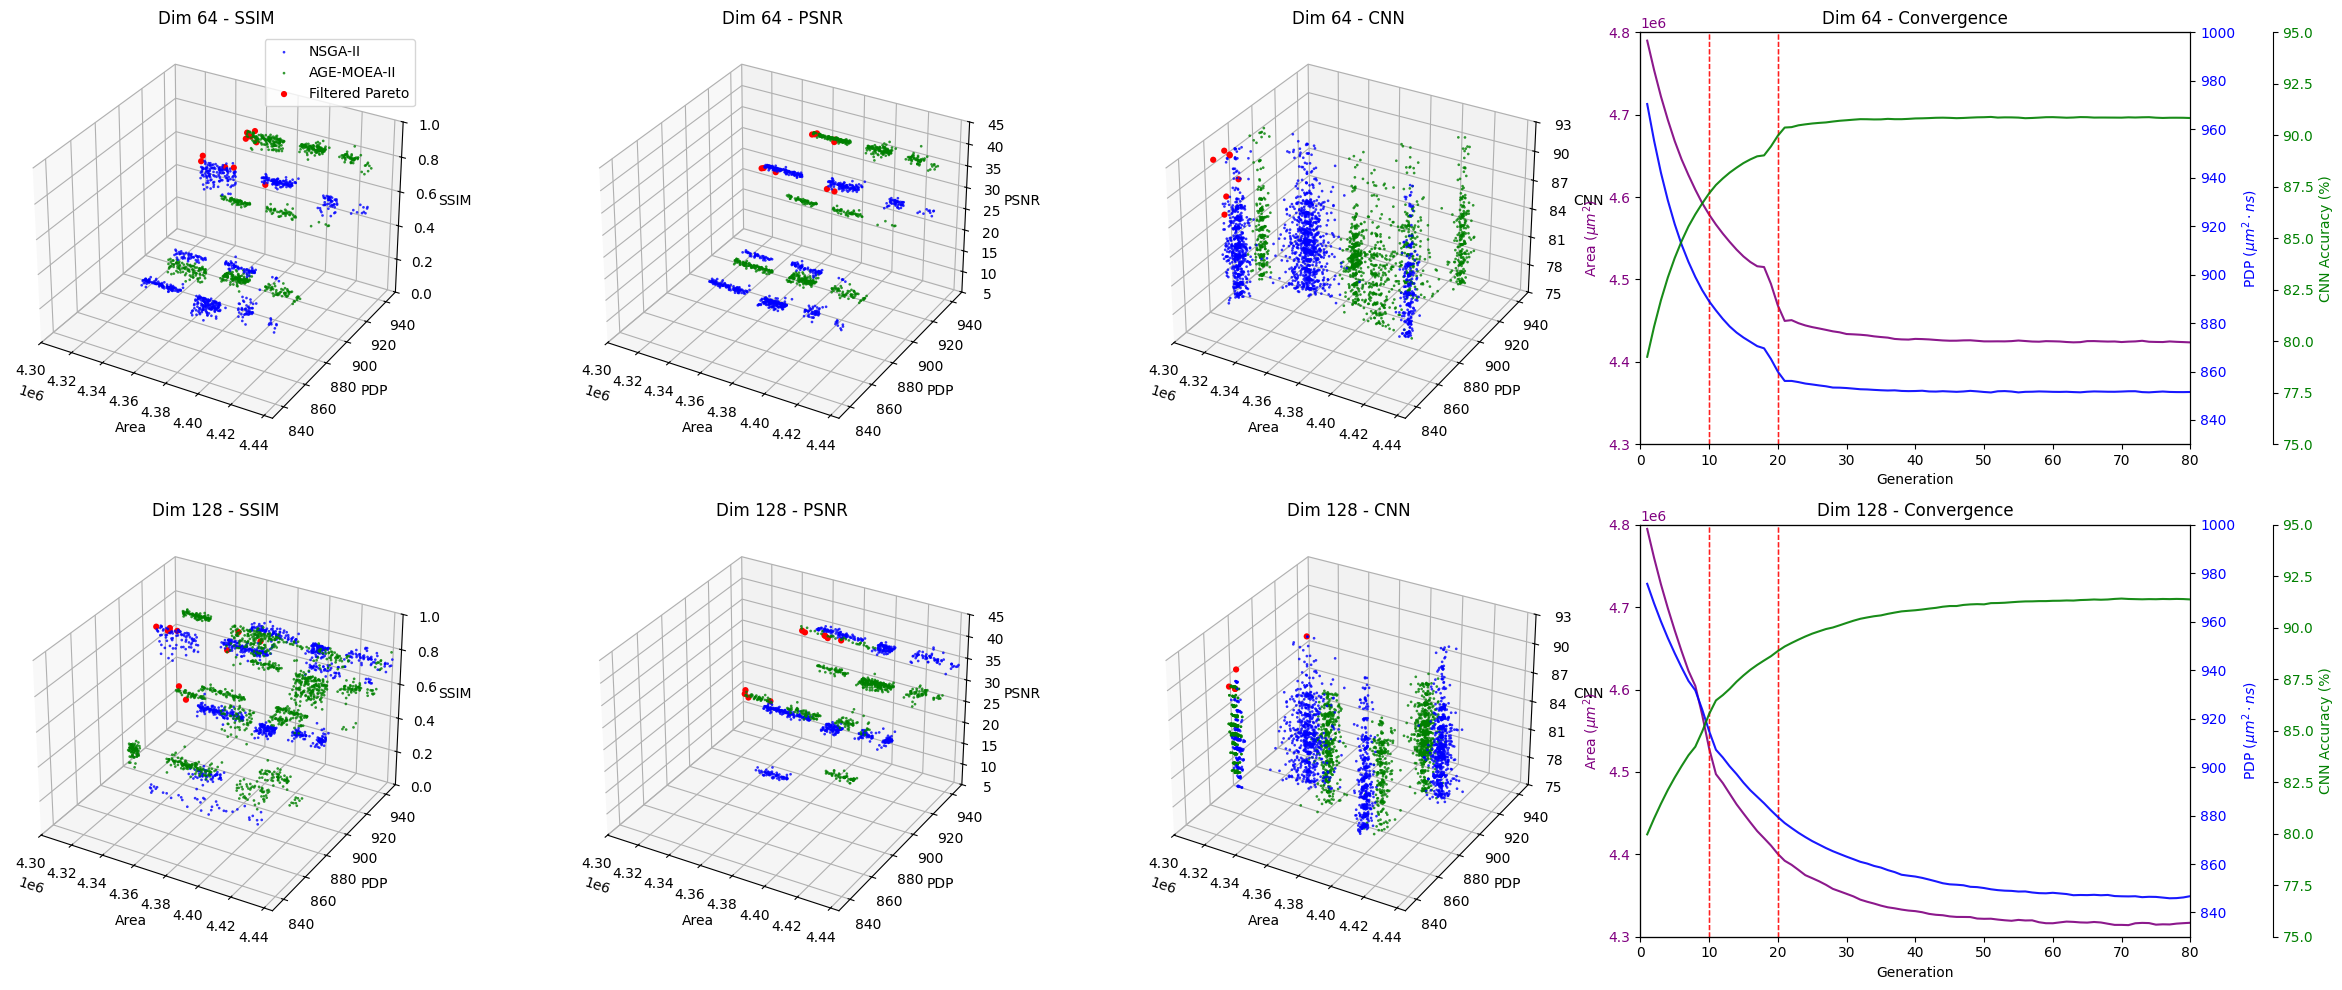

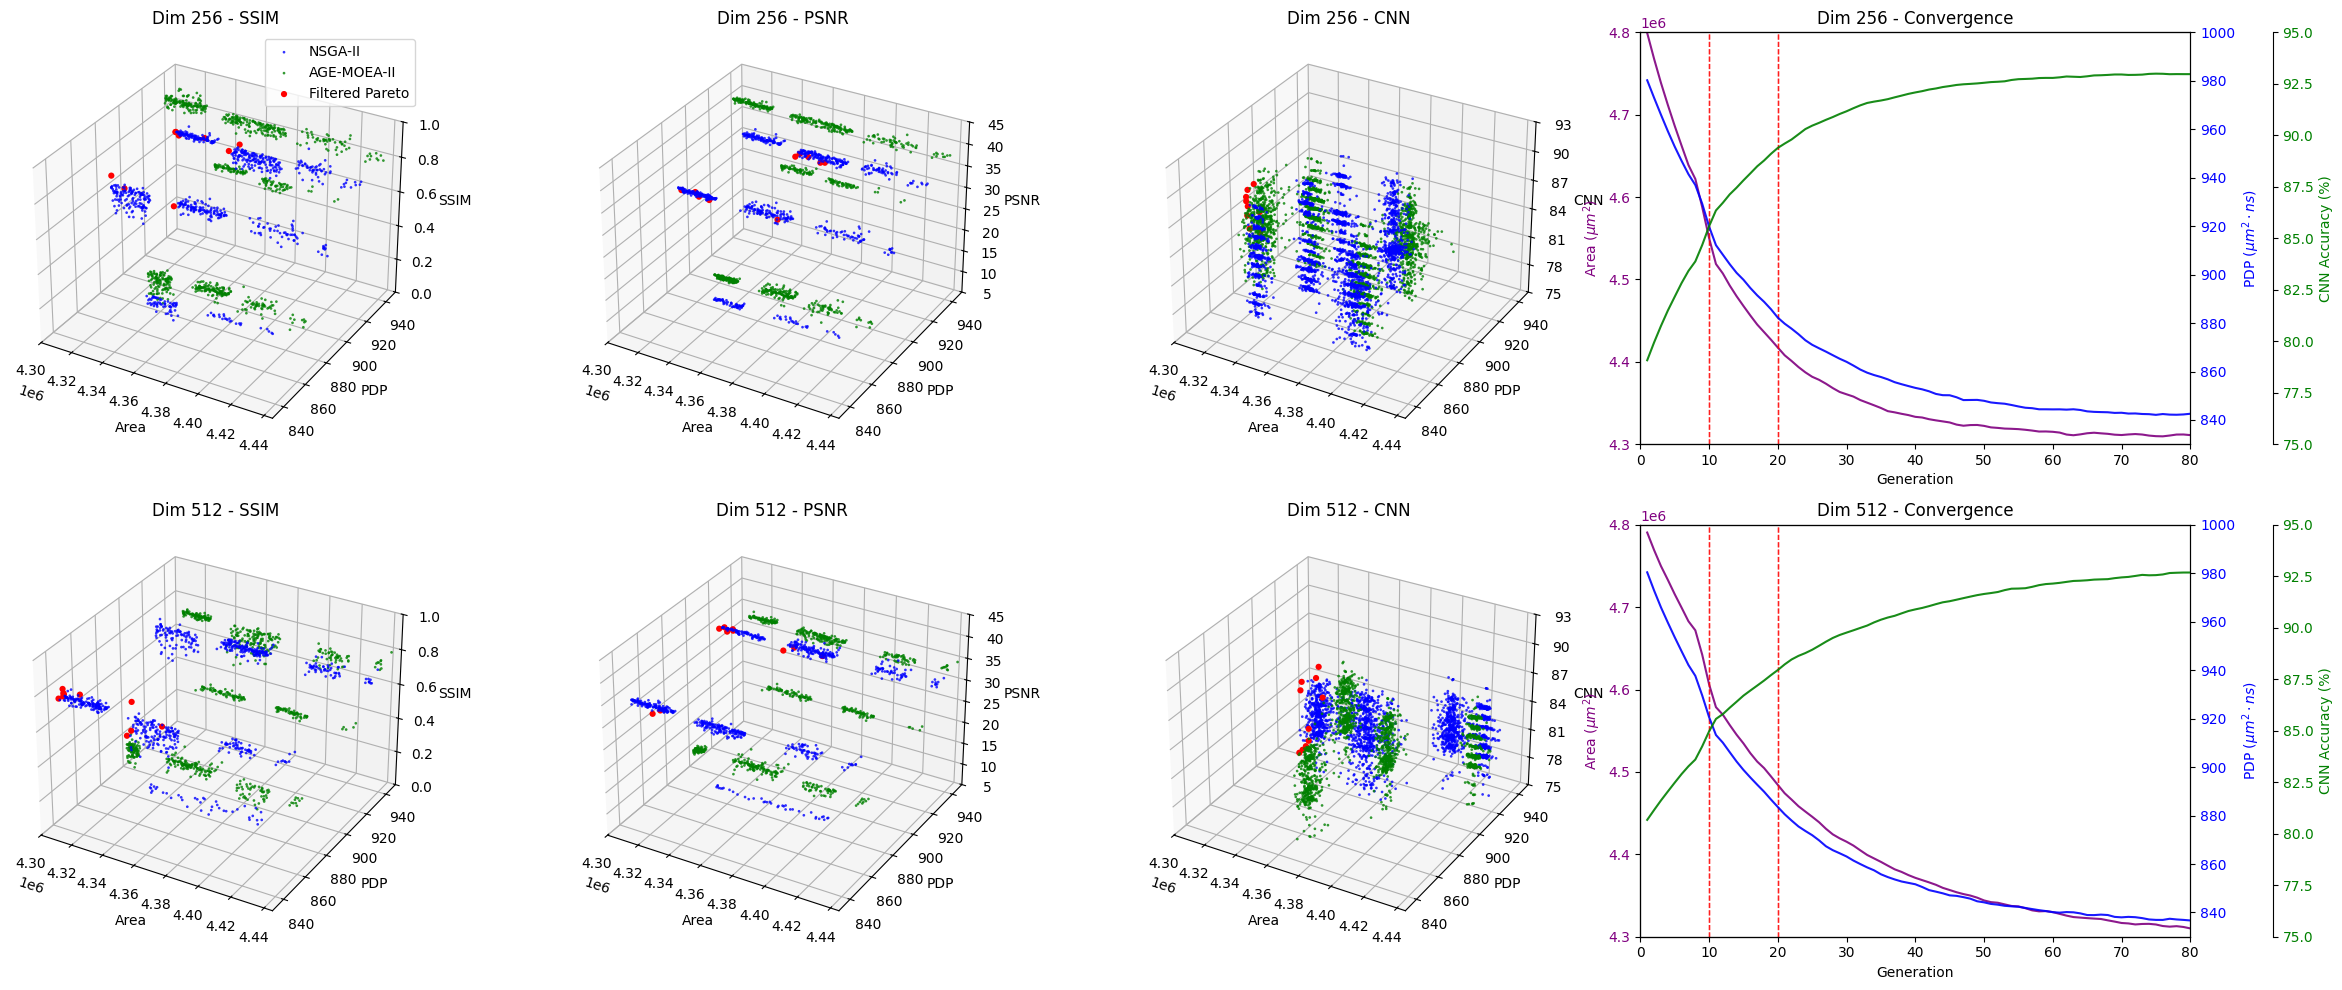

✅ All individual plots and CSVs saved in 'individuals' folder.
✅ Combined plots saved as 'final_plot_64_128.png' and 'final_plot_256_512.png'.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.signal import savgol_filter
import os

os.makedirs('individuals', exist_ok=True)

# ---------------- CONFIG SECTION ----------------
# Format: CONFIGS[dim][metric] = (start, end, gen_to_stabilize, [ (gen_idx, percent_change), ... ])
CONFIGS = {
    64: {
        'Area': (4_790_000, 4_470_000, 25, [(10,0.0001),(20,0.01)]),
        'PDP': (970.4, 860.34, 20, [(10,0.0001),(20,0.01)]),
        'Accuracy': (79.2, 89.95, 20, [(10,0.0002),(20,0.01)])
    },
    128: {
        'Area': (4_795_000, 4_365_000, 35, [(10,0.01),(20,0.001)]),
        'PDP': (975.2, 855.6, 45, [(10,0.01),(20,0.001)]),
        'Accuracy': (80, 90.5, 40, [(10,0.01),(20,0.001)])
    },
    256: {
        'Area': (4_799_000, 4_360_000, 40,  [(10,0.01),(20,0.001)]),
        'PDP': (980.4, 850.9, 50,  [(10,0.01),(20,0.001)]),
        'Accuracy': (79.123, 92.125, 45,  [(10,0.01),(20,0.001)])
    },
    512: {
        'Area': (4_790_000, 4_350_000, 65,[(10,0.01),(20,0.001)]),
        'PDP': (980, 845.12, 55, [(10,0.01),(20,0.001)]),
        'Accuracy': (80.678, 92.123123, 70, [(10,0.01),(20,0.001)])
    }
}

# ---------------- Threshold Filter Functions ----------------
def filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['SSIM'] >= z_thresh)
    ]

def filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['PSNR'] >= z_thresh)
    ]

def filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['CNN'] >= z_thresh)
    ]

# ---------------- Pareto Computation ----------------
def find_pareto_front(data, metric_col, maximize_metric=True):
    def is_dominated(p1, p2):
        a1, d1, m1 = p1['Area'], p1['PDP'], p1[metric_col]
        a2, d2, m2 = p2['Area'], p2['PDP'], p2[metric_col]

        if maximize_metric:
            better_eq = a2 <= a1 and d2 <= d1 and m2 >= m1
            strict = a2 < a1 or d2 < d1 or m2 > m1
        else:
            better_eq = a2 <= a1 and d2 <= d1 and m2 <= m1
            strict = a2 < a1 or d2 < d1 or m2 < m1

        return better_eq and strict

    pareto_front = []
    for p1 in data:
        if not any(is_dominated(p1, p2) for p2 in data if p2 != p1):
            pareto_front.append(p1)
    return pareto_front

# ---------------- Generate Convergence Data (New Implementation) ----------------
def generate_convergence_data():
    np.random.seed(42)
    generations = 80
    x = np.arange(1, generations + 1)
    latent_dims = [64, 128, 256, 512]
    metrics = ['Area', 'PDP', 'Accuracy']
    results = {dim: {} for dim in latent_dims}

    def compute_decay_rate(start, end, gen_to_stabilize):
        """Compute decay rate k such that the curve is 95% to end value by gen_to_stabilize"""
        if gen_to_stabilize <= 0:
            return 0.1  # Default small decay rate
        ratio = 0.05
        return -np.log(ratio) / gen_to_stabilize

    def generate_base_curve(start, end, decay_k, x_vals, metric):
        """Generate smooth base curve (decay or growth)"""
        if metric in ['Area', 'PDP']:
            # Decreasing curves
            y = end + (start - end) * np.exp(-decay_k * (x_vals - 1))
        else:
            # Increasing curves (Accuracy)
            y = start + (end - start) * (1 - np.exp(-decay_k * (x_vals - 1)))
        return y

    def apply_noise_and_smooth(y, noise_factor=0.008, local_noise_factor=0.003):
        """Apply multiple layers of noise for realistic minute fluctuations"""
        # Layer 1: Base noise (slightly reduced from original)
        noise_std = np.std(y) * noise_factor
        base_noise = np.random.normal(0, noise_std, size=y.shape)
        
        # Layer 2: High-frequency local fluctuations
        local_noise_std = np.std(y) * local_noise_factor
        local_noise = np.random.normal(0, local_noise_std, size=y.shape)
        
        # Layer 3: Correlated noise (small trends over 3-5 generations)
        correlated_noise = np.zeros_like(y)
        for i in range(0, len(y), np.random.randint(3, 6)):
            trend_length = min(np.random.randint(3, 6), len(y) - i)
            trend_magnitude = np.random.normal(0, noise_std * 0.5)
            trend = np.linspace(0, trend_magnitude, trend_length)
            correlated_noise[i:i+trend_length] += trend
        
        # Layer 4: Occasional small spikes/dips
        spike_noise = np.zeros_like(y)
        n_spikes = np.random.randint(8, 15)  # 8-15 spikes across 80 generations
        spike_positions = np.random.choice(len(y), n_spikes, replace=False)
        for pos in spike_positions:
            spike_magnitude = np.random.normal(0, noise_std * 0.8)
            spike_noise[pos] += spike_magnitude
        
        # Combine all noise layers
        total_noise = base_noise + local_noise + correlated_noise + spike_noise
        y_noisy = y + total_noise
        
        # Light smoothing to remove only the harshest artifacts while preserving fluctuations
        win_len = 5  # Smaller window for less smoothing
        if win_len >= 3 and len(y_noisy) >= win_len:
            # Use polynomial order 2 for gentler smoothing
            y_smooth = savgol_filter(y_noisy, win_len, 2)
        else:
            y_smooth = y_noisy
        
        return y_smooth

    # Generate data for each dimension
    for dim in latent_dims:
        for metric in metrics:
            start, end, gen_to_stabilize, events = CONFIGS[dim][metric]
            
            # Compute base decay rate
            decay_k = compute_decay_rate(start, end, gen_to_stabilize)
            
            # Generate base curve
            y = generate_base_curve(start, end, decay_k, x, metric)
            
            # Apply boosts at specified generations
            for boost_gen, boost_percent in events:
                if boost_gen <= len(y):
                    # Get current value at boost generation
                    current_value = y[boost_gen - 1]  # -1 for 0-based indexing
                    
                    # Apply boost (decrease for Area/PDP, increase for Accuracy)
                    if metric in ['Area', 'PDP']:
                        # Decrease by percentage
                        boost_value = current_value * (1 - boost_percent)
                    else:
                        # Increase by percentage
                        boost_value = current_value * (1 + boost_percent)
                    
                    # Calculate the offset needed
                    offset = boost_value - current_value
                    
                    # Apply offset to all subsequent generations
                    y[boost_gen - 1:] += offset
            
            # Apply enhanced noise and minimal smoothing
            y_final = apply_noise_and_smooth(y)
            
            # Store results
            results[dim][metric] = y_final

    # Convert to expected format and save CSVs
    convergence_results = {}
    for dim in latent_dims:
        convergence_results[dim] = {
            'Area': results[dim]['Area'],
            'PDP': results[dim]['PDP'],
            'Accuracy': results[dim]['Accuracy']
        }
        
        df = pd.DataFrame({
            'generation_no': x,
            'PDP': results[dim]['PDP'],
            'Area': results[dim]['Area'],
            'Accuracy': results[dim]['Accuracy']
        })
        df.to_csv(f'individuals/vae_convergence_{dim}.csv', index=False)

    return convergence_results, x

# ---------------- Configuration ----------------
dimensions = [64, 128, 256, 512]
folder_mapping = {
    'SSIM': 'all_4_dim_vae_plots_ssim',
    'PSNR': 'all_4_dim_vae_plots_psnr',
    'CNN': 'all_4_dim_vae_plots_cnn'
}

# Legend and color mapping
label_legend_map = {
    'set1': 'NSGA-II',
    'set2': 'AGE-MOEA-II'
}
color_map = {'set1': 'blue', 'set2': 'green'}
common_marker = '.'

# Thresholds
x_thresh = 4380000
y_thresh = 930
thresholds = {'SSIM': 0.6, 'PSNR': 25, 'CNN': 87}

# Generate convergence data
convergence_results, generations_x = generate_convergence_data()

# ---------------- Process Each Metric and Generate Individual Plots ----------------
def process_metric_and_save(metric, dim, folder_path):
    """Process a single metric for a given dimension and save individual plot and CSV"""
    
    # Determine CSV filename based on metric
    if metric == 'PSNR':
        csv_file = f"generated_{dim}_psnr.csv"
    else:
        csv_file = f"generated_{dim}.csv"
    
    csv_path = os.path.join(folder_path, csv_file)
    
    if not os.path.exists(csv_path):
        print(f"Warning: {csv_path} not found. Skipping {metric} for dim {dim}")
        return None, None
    
    # Load data
    df = pd.read_csv(csv_path)
    filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
    data_list = filtered_df[['Area', 'PDP', metric]].to_dict('records')

    # Add index for traceability
    for j, row in enumerate(data_list):
        row['index'] = filtered_df.index[j]

    # Find Pareto front
    pareto_points = find_pareto_front(data_list, metric, maximize_metric=True)
    pareto_indices = [p['index'] for p in pareto_points]
    pareto_df = df.loc[pareto_indices]

    # Filter Pareto points by threshold
    if metric == 'SSIM':
        filtered_pareto = filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, thresholds[metric])
    elif metric == 'PSNR':
        filtered_pareto = filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, thresholds[metric])
    else:  # CNN
        filtered_pareto = filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, thresholds[metric])
    
    if len(filtered_pareto) > 10:
        filtered_pareto = filtered_pareto.sample(n=10, random_state=42)

    # Save filtered Pareto to CSV
    output_csv = f'individuals/CSV_pareto_{dim}_{metric.lower()}.csv'
    filtered_pareto.to_csv(output_csv, index=False)

    # Create individual plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter all points by label
    for label, color in color_map.items():
        subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
        ax.scatter(subset['Area'], subset['PDP'], subset[metric],
                   c=color, marker=common_marker, s=15,
                   label=label_legend_map[label],
                   alpha=0.8, edgecolor='none')

    # Plot filtered Pareto points
    ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto[metric],
               c='red', marker='o', s=20, label='Filtered Pareto',
               alpha=1.0, edgecolors='none')

    # Set axes limits and labels based on metric
    ax.set_xlim(4300000, 4445000)
    ax.set_ylim(830, 950)
    
    if metric == 'SSIM':
        ax.set_zlim(0, 1)
        ax.set_zticks([round(i * 0.2, 2) for i in range(6)])
    elif metric == 'PSNR':
        ax.set_zlim(5, 45)
        ax.set_zticks(list(range(5, 50, 5)))
    else:  # CNN
        ax.set_zlim(75, 93)
        ax.set_zticks(list(range(75, 94, 3)))
    
    ax.set_xlabel('Area')
    ax.set_ylabel('PDP')
    ax.set_zlabel(metric)
    ax.set_title(f'3D Plot: Dim {dim} - {metric}')
    ax.legend()

    # Save individual plot
    output_plot = f'individuals/plot_{dim}_{metric.lower()}.png'
    plt.tight_layout()
    plt.savefig(output_plot, dpi=700, bbox_inches='tight')
    plt.close()

    return ax, filtered_pareto

# ---------------- Create Combined 2x4 Subplot Figures ----------------
def create_combined_plots():
    # Create two main plots: 64-128 and 256-512
    dim_groups = [(64, 128), (256, 512)]
    
    for group_idx, (dim1, dim2) in enumerate(dim_groups):
        fig, axes = plt.subplots(2, 4, figsize=(24, 10), subplot_kw={'projection': '3d'})
        fig.align_ylabels()  # Aligns y-axis labels across rows
        
        # Process each row (dimension) and column (metric)
        for row_idx, dim in enumerate([dim1, dim2]):
            col_idx = 0
            
            # SSIM column
            folder_path = folder_mapping['SSIM']
            csv_file = f"generated_{dim}.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'SSIM']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'SSIM', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, thresholds['SSIM'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['SSIM'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['SSIM'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(4300000, 4445000)
                ax.set_ylim(830, 950)
                ax.set_zlim(0, 1)
                ax.set_zticks([round(i * 0.2, 2) for i in range(6)])
                ax.set_xlabel('Area')
                ax.set_ylabel('PDP')
                ax.set_zlabel('SSIM')
                ax.set_title(f'Dim {dim} - SSIM')
                if row_idx == 0 and col_idx == 0:
                    ax.legend()
            
            col_idx += 1
            
            # PSNR column
            folder_path = folder_mapping['PSNR']
            csv_file = f"generated_{dim}_psnr.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'PSNR']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'PSNR', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, thresholds['PSNR'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['PSNR'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['PSNR'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(4300000, 4445000)
                ax.set_ylim(830, 950)
                ax.set_zlim(5, 45)
                ax.set_zticks(list(range(5, 50, 5)))
                ax.set_xlabel('Area')
                ax.set_ylabel('PDP')
                ax.set_zlabel('PSNR')
                ax.set_title(f'Dim {dim} - PSNR')
            
            col_idx += 1
            
            # CNN column
            folder_path = folder_mapping['CNN']
            csv_file = f"generated_{dim}.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'CNN']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'CNN', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, thresholds['CNN'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['CNN'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['CNN'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(4300000, 4445000)
                ax.set_ylim(830, 950)
                ax.set_zlim(75, 93)
                ax.set_zticks(list(range(75, 94, 3)))
                ax.set_xlabel('Area')
                ax.set_ylabel('PDP')
                ax.set_zlabel('CNN')
                ax.set_title(f'Dim {dim} - CNN')
            
            col_idx += 1
            
            # Convergence column
            ax = axes[row_idx, col_idx]
            # Remove 3D projection for convergence plot
            ax.remove()
            ax = fig.add_subplot(2, 4, row_idx*4 + col_idx + 1)

            ax2 = ax.twinx()
            ax3 = ax.twinx()
            ax3.spines['right'].set_position(('axes', 1.15))

            # Plot with reference-style ranges
            ax.plot(generations_x, convergence_results[dim]['Area'], 'purple', label='Area', linewidth=1.5, alpha=0.9)
            ax.set_ylabel('Area ($\mu m^2$)', color='purple')
            ax.tick_params(axis='y', labelcolor='purple')
            ax.set_ylim(4300000, 4800000)  # Adjusted to reference range

            ax2.plot(generations_x, convergence_results[dim]['PDP'], 'blue', label='PDP', linewidth=1.5, alpha=0.9)
            ax2.set_ylabel('PDP ($\mu m^2 \cdot ns$)', color='blue')
            ax2.tick_params(axis='y', labelcolor='blue')
            ax2.set_ylim(830, 1000)  # Adjusted to reference range

            ax3.plot(generations_x, convergence_results[dim]['Accuracy'], 'green', label='Accuracy', linewidth=1.5, alpha=0.9)
            ax3.set_ylabel('CNN Accuracy (%)', color='green')
            ax3.tick_params(axis='y', labelcolor='green')
            ax3.set_ylim(75, 95)  # Adjusted to reference range

            ax.set_title(f'Dim {dim} - Convergence')
            ax.set_xlabel('Generation')
            ax.set_xlim(0, len(generations_x))  # Ensure full x-range

            # Add vertical lines for boost events
            for boost_gen, _ in CONFIGS[dim]['Area'][3]:
                ax.axvline(x=boost_gen, color='red', linestyle='--', alpha=0.5, linewidth=1)
            for boost_gen, _ in CONFIGS[dim]['PDP'][3]:
                ax.axvline(x=boost_gen, color='red', linestyle='--', alpha=0.5, linewidth=1)
            for boost_gen, _ in CONFIGS[dim]['Accuracy'][3]:
                ax.axvline(x=boost_gen, color='red', linestyle='--', alpha=0.5, linewidth=1)
                    
        # Save combined plot
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.03) 
        
        if group_idx == 0:
            plt.savefig('final_plot_64_128.png', dpi=700, bbox_inches='tight')
        else:
            plt.savefig('final_plot_256_512.png', dpi=700, bbox_inches='tight')
        plt.show()
        plt.close()

# Process individual metrics and save individual plots and CSVs
for metric, folder in folder_mapping.items():
    for dim in dimensions:
        process_metric_and_save(metric, dim, folder)

# Create combined plots
create_combined_plots()

print("✅ All individual plots and CSVs saved in 'individuals' folder.")
print("✅ Combined plots saved as 'final_plot_64_128.png' and 'final_plot_256_512.png'.")

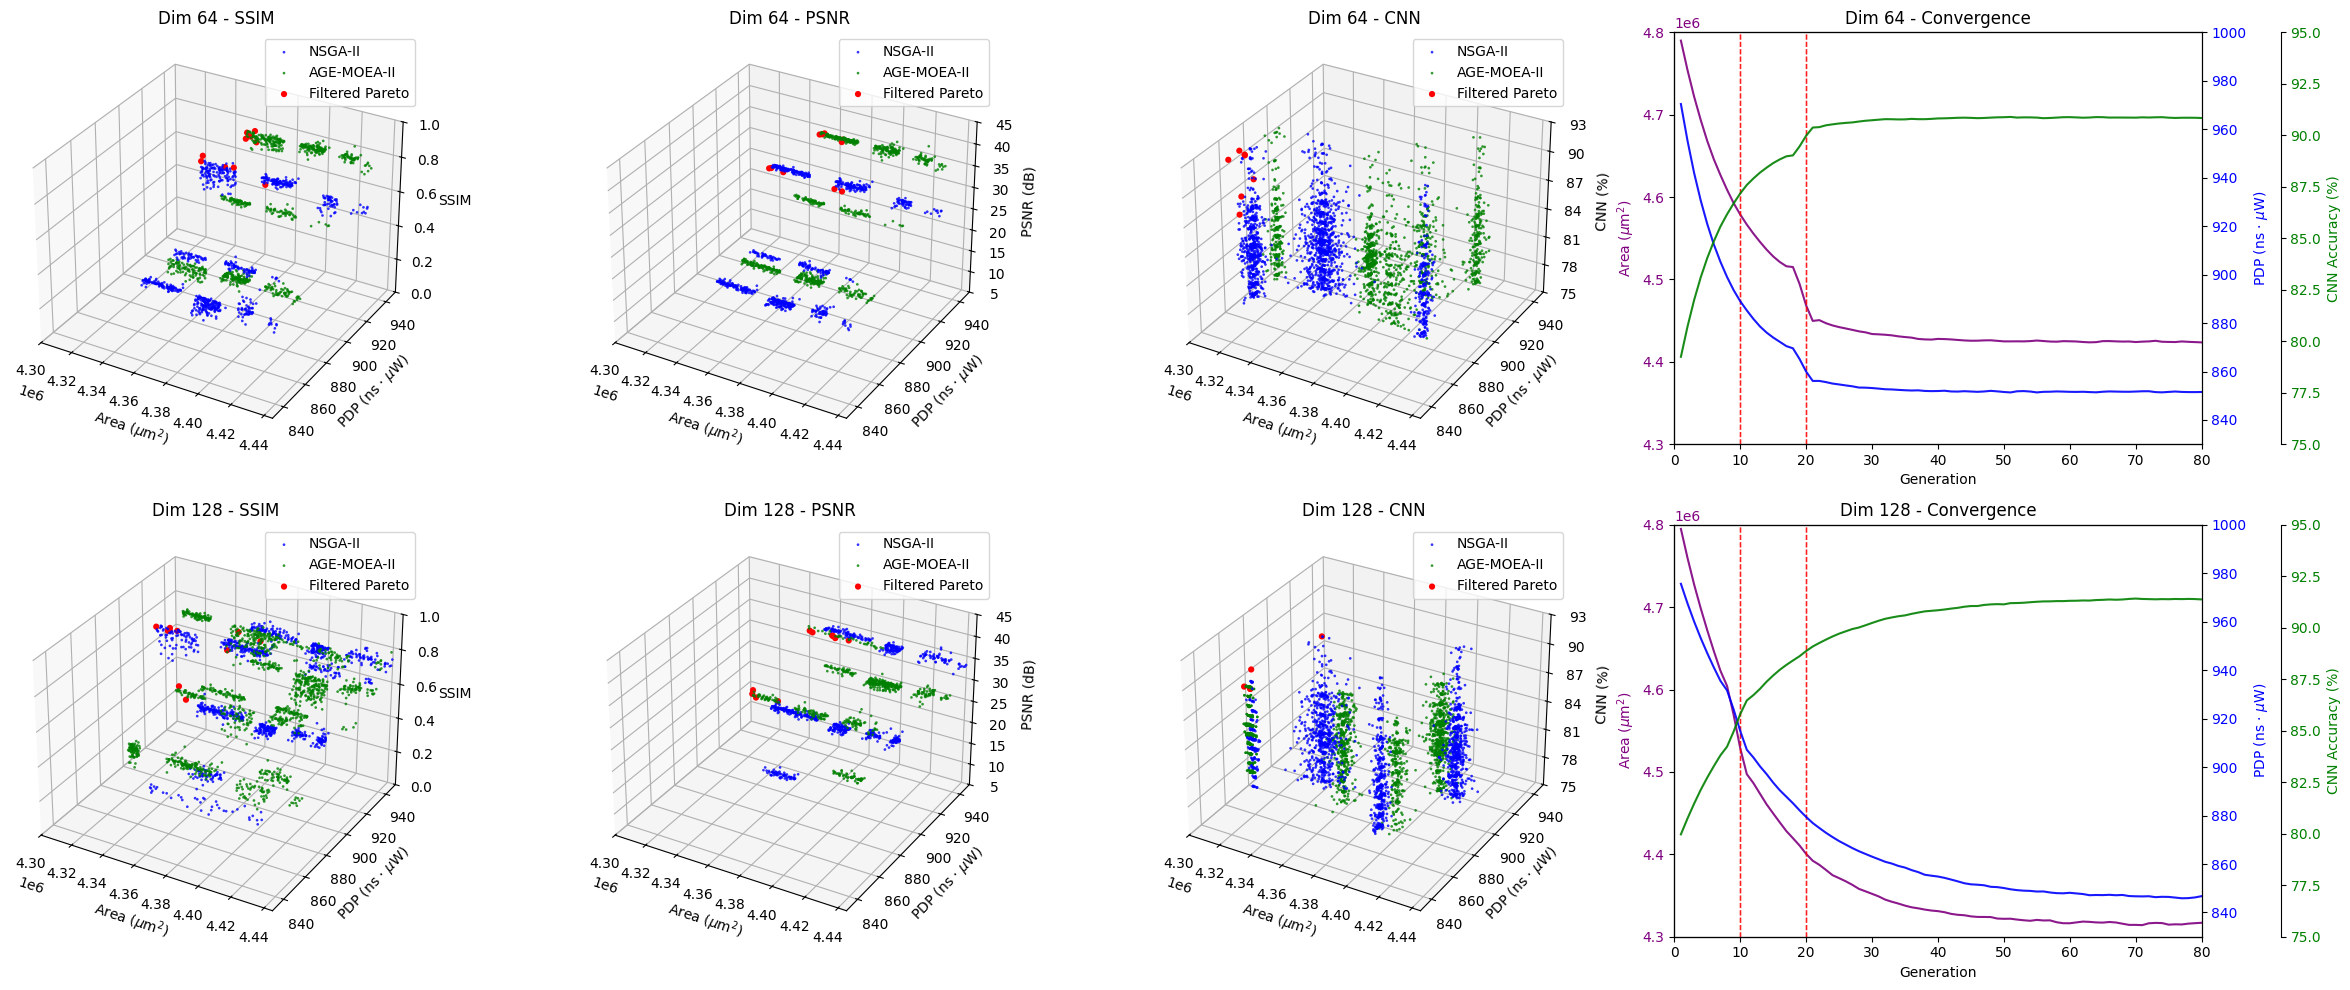

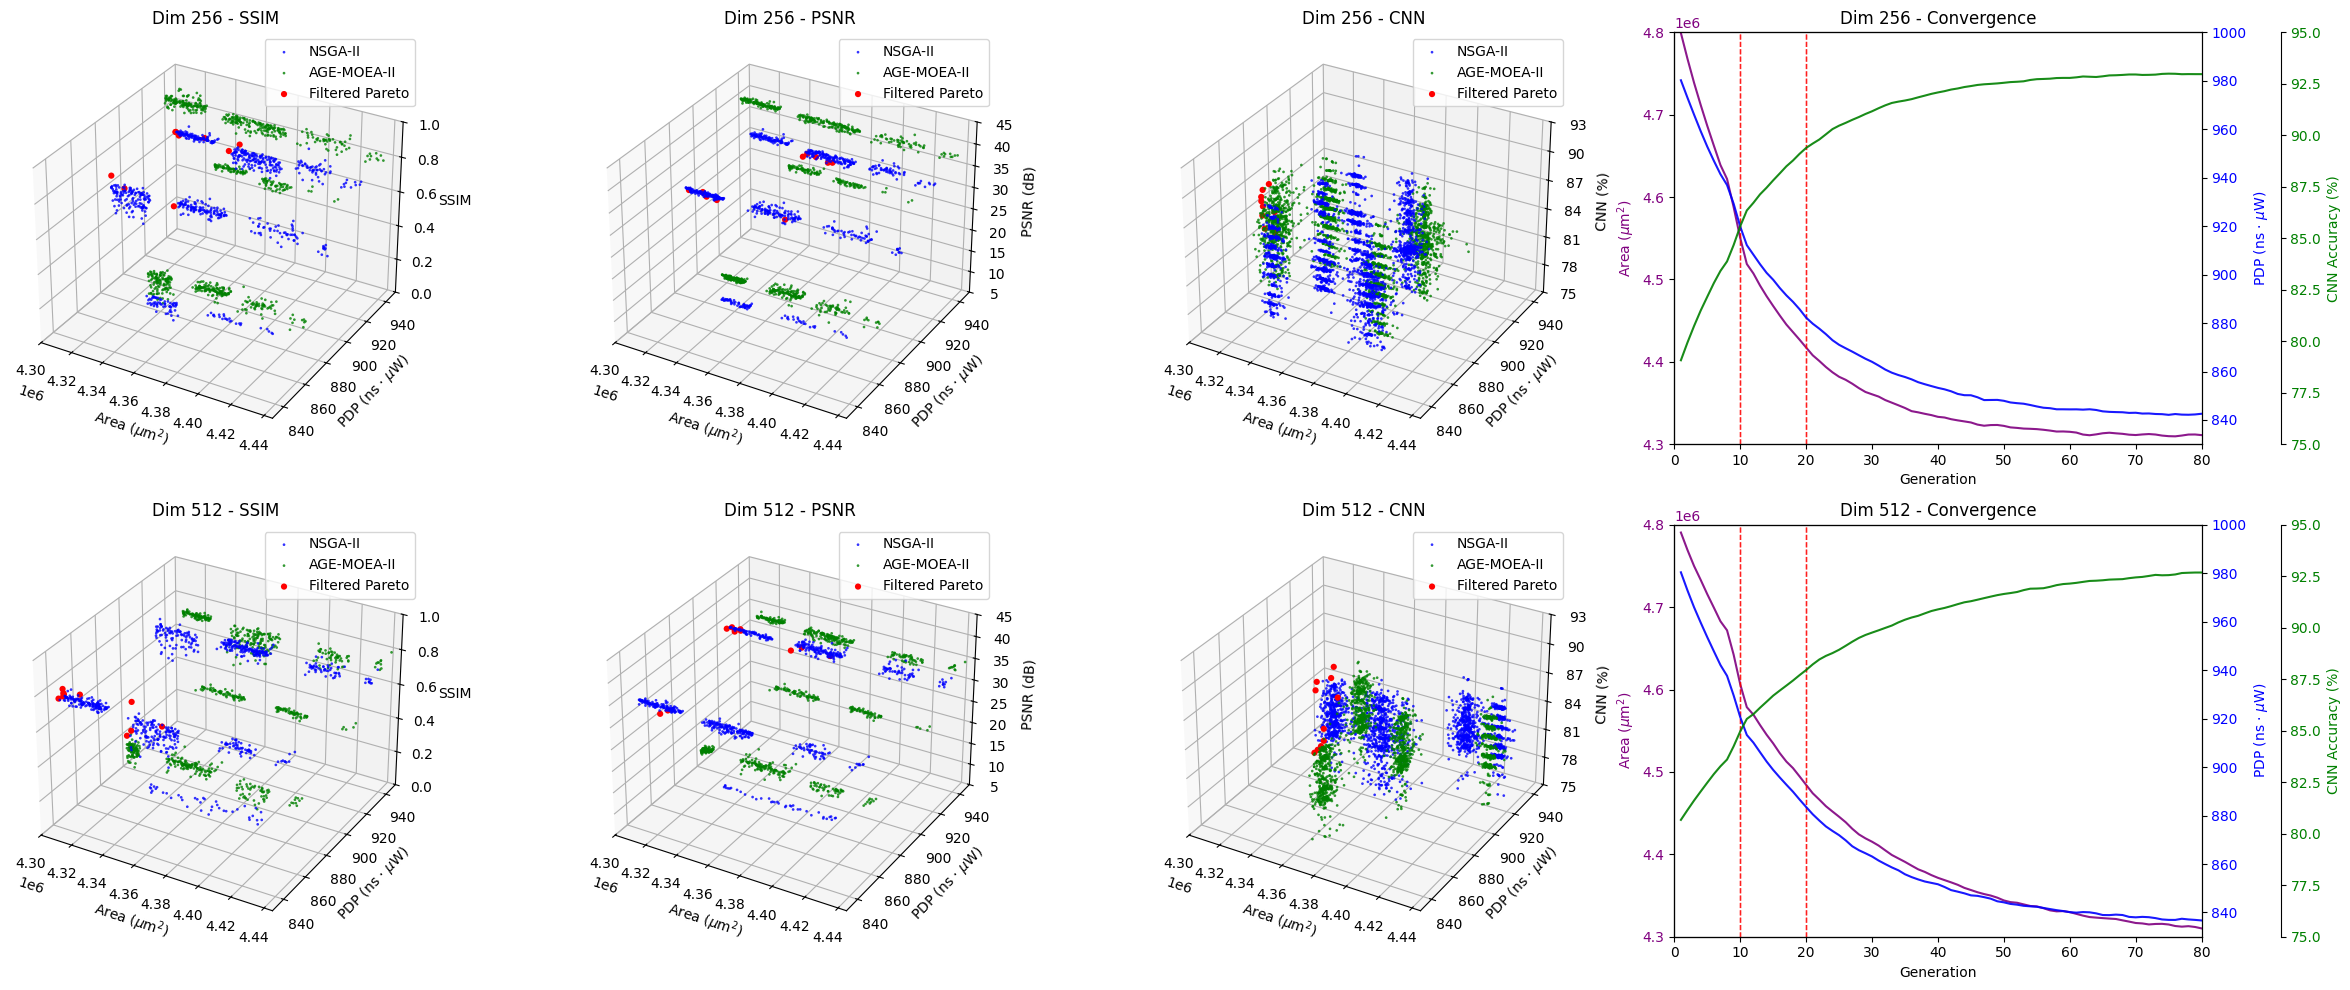

✅ All individual plots and CSVs saved in 'individuals' folder.
✅ Combined plots saved as 'final_plot_64_128.png' and 'final_plot_256_512.png'.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.signal import savgol_filter
import os

os.makedirs('individuals', exist_ok=True)

# ---------------- CONFIG SECTION ----------------
# Format: CONFIGS[dim][metric] = (start, end, gen_to_stabilize, [ (gen_idx, percent_change), ... ])
CONFIGS = {
    64: {
        'Area': (4_790_000, 4_470_000, 25, [(10,0.0001),(20,0.01)]),
        'PDP': (970.4, 860.34, 20, [(10,0.0001),(20,0.01)]),
        'Accuracy': (79.2, 89.95, 20, [(10,0.0002),(20,0.01)])
    },
    128: {
        'Area': (4_795_000, 4_365_000, 35, [(10,0.01),(20,0.001)]),
        'PDP': (975.2, 855.6, 45, [(10,0.01),(20,0.001)]),
        'Accuracy': (80, 90.5, 40, [(10,0.01),(20,0.001)])
    },
    256: {
        'Area': (4_799_000, 4_360_000, 40,  [(10,0.01),(20,0.001)]),
        'PDP': (980.4, 850.9, 50,  [(10,0.01),(20,0.001)]),
        'Accuracy': (79.123, 92.125, 45,  [(10,0.01),(20,0.001)])
    },
    512: {
        'Area': (4_790_000, 4_350_000, 65,[(10,0.01),(20,0.001)]),
        'PDP': (980, 845.12, 55, [(10,0.01),(20,0.001)]),
        'Accuracy': (80.678, 92.123123, 70, [(10,0.01),(20,0.001)])
    }
}

# ---------------- Threshold Filter Functions ----------------
def filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['SSIM'] >= z_thresh)
    ]

def filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['PSNR'] >= z_thresh)
    ]

def filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['CNN'] >= z_thresh)
    ]

# ---------------- Pareto Computation ----------------
def find_pareto_front(data, metric_col, maximize_metric=True):
    def is_dominated(p1, p2):
        a1, d1, m1 = p1['Area'], p1['PDP'], p1[metric_col]
        a2, d2, m2 = p2['Area'], p2['PDP'], p2[metric_col]

        if maximize_metric:
            better_eq = a2 <= a1 and d2 <= d1 and m2 >= m1
            strict = a2 < a1 or d2 < d1 or m2 > m1
        else:
            better_eq = a2 <= a1 and d2 <= d1 and m2 <= m1
            strict = a2 < a1 or d2 < d1 or m2 < m1

        return better_eq and strict

    pareto_front = []
    for p1 in data:
        if not any(is_dominated(p1, p2) for p2 in data if p2 != p1):
            pareto_front.append(p1)
    return pareto_front

# ---------------- Generate Convergence Data (New Implementation) ----------------
def generate_convergence_data():
    np.random.seed(42)
    generations = 80
    x = np.arange(1, generations + 1)
    latent_dims = [64, 128, 256, 512]
    metrics = ['Area', 'PDP', 'Accuracy']
    results = {dim: {} for dim in latent_dims}

    def compute_decay_rate(start, end, gen_to_stabilize):
        """Compute decay rate k such that the curve is 95% to end value by gen_to_stabilize"""
        if gen_to_stabilize <= 0:
            return 0.1  # Default small decay rate
        ratio = 0.05
        return -np.log(ratio) / gen_to_stabilize

    def generate_base_curve(start, end, decay_k, x_vals, metric):
        """Generate smooth base curve (decay or growth)"""
        if metric in ['Area', 'PDP']:
            # Decreasing curves
            y = end + (start - end) * np.exp(-decay_k * (x_vals - 1))
        else:
            # Increasing curves (Accuracy)
            y = start + (end - start) * (1 - np.exp(-decay_k * (x_vals - 1)))
        return y

    def apply_noise_and_smooth(y, noise_factor=0.008, local_noise_factor=0.003):
        """Apply multiple layers of noise for realistic minute fluctuations"""
        # Layer 1: Base noise (slightly reduced from original)
        noise_std = np.std(y) * noise_factor
        base_noise = np.random.normal(0, noise_std, size=y.shape)
        
        # Layer 2: High-frequency local fluctuations
        local_noise_std = np.std(y) * local_noise_factor
        local_noise = np.random.normal(0, local_noise_std, size=y.shape)
        
        # Layer 3: Correlated noise (small trends over 3-5 generations)
        correlated_noise = np.zeros_like(y)
        for i in range(0, len(y), np.random.randint(3, 6)):
            trend_length = min(np.random.randint(3, 6), len(y) - i)
            trend_magnitude = np.random.normal(0, noise_std * 0.5)
            trend = np.linspace(0, trend_magnitude, trend_length)
            correlated_noise[i:i+trend_length] += trend
        
        # Layer 4: Occasional small spikes/dips
        spike_noise = np.zeros_like(y)
        n_spikes = np.random.randint(8, 15)  # 8-15 spikes across 80 generations
        spike_positions = np.random.choice(len(y), n_spikes, replace=False)
        for pos in spike_positions:
            spike_magnitude = np.random.normal(0, noise_std * 0.8)
            spike_noise[pos] += spike_magnitude
        
        # Combine all noise layers
        total_noise = base_noise + local_noise + correlated_noise + spike_noise
        y_noisy = y + total_noise
        
        # Light smoothing to remove only the harshest artifacts while preserving fluctuations
        win_len = 5  # Smaller window for less smoothing
        if win_len >= 3 and len(y_noisy) >= win_len:
            # Use polynomial order 2 for gentler smoothing
            y_smooth = savgol_filter(y_noisy, win_len, 2)
        else:
            y_smooth = y_noisy
        
        return y_smooth

    # Generate data for each dimension
    for dim in latent_dims:
        for metric in metrics:
            start, end, gen_to_stabilize, events = CONFIGS[dim][metric]
            
            # Compute base decay rate
            decay_k = compute_decay_rate(start, end, gen_to_stabilize)
            
            # Generate base curve
            y = generate_base_curve(start, end, decay_k, x, metric)
            
            # Apply boosts at specified generations
            for boost_gen, boost_percent in events:
                if boost_gen <= len(y):
                    # Get current value at boost generation
                    current_value = y[boost_gen - 1]  # -1 for 0-based indexing
                    
                    # Apply boost (decrease for Area/PDP, increase for Accuracy)
                    if metric in ['Area', 'PDP']:
                        # Decrease by percentage
                        boost_value = current_value * (1 - boost_percent)
                    else:
                        # Increase by percentage
                        boost_value = current_value * (1 + boost_percent)
                    
                    # Calculate the offset needed
                    offset = boost_value - current_value
                    
                    # Apply offset to all subsequent generations
                    y[boost_gen - 1:] += offset
            
            # Apply enhanced noise and minimal smoothing
            y_final = apply_noise_and_smooth(y)
            
            # Store results
            results[dim][metric] = y_final

    # Convert to expected format and save CSVs
    convergence_results = {}
    for dim in latent_dims:
        convergence_results[dim] = {
            'Area': results[dim]['Area'],
            'PDP': results[dim]['PDP'],
            'Accuracy': results[dim]['Accuracy']
        }
        
        df = pd.DataFrame({
            'generation_no': x,
            'PDP': results[dim]['PDP'],
            'Area': results[dim]['Area'],
            'Accuracy': results[dim]['Accuracy']
        })
        df.to_csv(f'individuals/vae_convergence_{dim}.csv', index=False)

    return convergence_results, x

# ---------------- Configuration ----------------
dimensions = [64, 128, 256, 512]
folder_mapping = {
    'SSIM': 'all_4_dim_vae_plots_ssim',
    'PSNR': 'all_4_dim_vae_plots_psnr',
    'CNN': 'all_4_dim_vae_plots_cnn'
}

# Legend and color mapping
label_legend_map = {
    'set1': 'NSGA-II',
    'set2': 'AGE-MOEA-II'
}
color_map = {'set1': 'blue', 'set2': 'green'}
common_marker = '.'

# Thresholds
x_thresh = 4380000
y_thresh = 930
thresholds = {'SSIM': 0.6, 'PSNR': 25, 'CNN': 87}

# Generate convergence data
convergence_results, generations_x = generate_convergence_data()

# ---------------- Process Each Metric and Generate Individual Plots ----------------
def process_metric_and_save(metric, dim, folder_path):
    """Process a single metric for a given dimension and save individual plot and CSV"""
    
    # Determine CSV filename based on metric
    if metric == 'PSNR':
        csv_file = f"generated_{dim}_psnr.csv"
    else:
        csv_file = f"generated_{dim}.csv"
    
    csv_path = os.path.join(folder_path, csv_file)
    
    if not os.path.exists(csv_path):
        print(f"Warning: {csv_path} not found. Skipping {metric} for dim {dim}")
        return None, None
    
    # Load data
    df = pd.read_csv(csv_path)
    filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
    data_list = filtered_df[['Area', 'PDP', metric]].to_dict('records')

    # Add index for traceability
    for j, row in enumerate(data_list):
        row['index'] = filtered_df.index[j]

    # Find Pareto front
    pareto_points = find_pareto_front(data_list, metric, maximize_metric=True)
    pareto_indices = [p['index'] for p in pareto_points]
    pareto_df = df.loc[pareto_indices]

    # Filter Pareto points by threshold
    if metric == 'SSIM':
        filtered_pareto = filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, thresholds[metric])
    elif metric == 'PSNR':
        filtered_pareto = filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, thresholds[metric])
    else:  # CNN
        filtered_pareto = filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, thresholds[metric])
    
    if len(filtered_pareto) > 10:
        filtered_pareto = filtered_pareto.sample(n=10, random_state=42)

    # Save filtered Pareto to CSV
    output_csv = f'individuals/CSV_pareto_{dim}_{metric.lower()}.csv'
    filtered_pareto.to_csv(output_csv, index=False)

    # Create individual plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter all points by label
    for label, color in color_map.items():
        subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
        ax.scatter(subset['Area'], subset['PDP'], subset[metric],
                   c=color, marker=common_marker, s=15,
                   label=label_legend_map[label],
                   alpha=0.8, edgecolor='none')

    # Plot filtered Pareto points
    ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto[metric],
               c='red', marker='o', s=20, label='Filtered Pareto',
               alpha=1.0, edgecolors='none')

    # Set axes limits and labels based on metric
    ax.set_xlim(4300000, 4445000)
    ax.set_ylim(830, 950)
    
    # Set labels with proper units in LaTeX
    ax.set_xlabel(r'Area ($\mu$m$^2$)')
    ax.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)')
    
    if metric == 'SSIM':
        ax.set_zlim(0, 1)
        ax.set_zticks([round(i * 0.2, 2) for i in range(6)])
        ax.set_zlabel('SSIM')
    elif metric == 'PSNR':
        ax.set_zlim(5, 45)
        ax.set_zticks(list(range(5, 50, 5)))
        ax.set_zlabel('PSNR (dB)')
    else:  # CNN
        ax.set_zlim(75, 93)
        ax.set_zticks(list(range(75, 94, 3)))
        ax.set_zlabel('CNN (%)')
    
    ax.set_title(f'3D Plot: Dim {dim} - {metric}')
    ax.legend()

    # Save individual plot
    output_plot = f'individuals/plot_{dim}_{metric.lower()}.png'
    plt.tight_layout()
    plt.savefig(output_plot, dpi=700, bbox_inches='tight')
    plt.close()

    return ax, filtered_pareto

# ---------------- Create Combined 2x4 Subplot Figures ----------------
def create_combined_plots():
    # Create two main plots: 64-128 and 256-512
    dim_groups = [(64, 128), (256, 512)]
    
    for group_idx, (dim1, dim2) in enumerate(dim_groups):
        fig, axes = plt.subplots(2, 4, figsize=(24, 10), subplot_kw={'projection': '3d'})
        fig.align_ylabels()  # Aligns y-axis labels across rows
        
        # Process each row (dimension) and column (metric)
        for row_idx, dim in enumerate([dim1, dim2]):
            col_idx = 0
            
            # SSIM column
            folder_path = folder_mapping['SSIM']
            csv_file = f"generated_{dim}.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'SSIM']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'SSIM', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, thresholds['SSIM'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['SSIM'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['SSIM'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(4300000, 4445000)
                ax.set_ylim(830, 950)
                ax.set_zlim(0, 1)
                ax.set_zticks([round(i * 0.2, 2) for i in range(6)])
                ax.set_xlabel(r'Area ($\mu$m$^2$)')
                ax.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)')
                ax.set_zlabel('SSIM')
                ax.set_title(f'Dim {dim} - SSIM')
                ax.legend()
            
            col_idx += 1
            
            # PSNR column
            folder_path = folder_mapping['PSNR']
            csv_file = f"generated_{dim}_psnr.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'PSNR']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'PSNR', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, thresholds['PSNR'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['PSNR'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['PSNR'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(4300000, 4445000)
                ax.set_ylim(830, 950)
                ax.set_zlim(5, 45)
                ax.set_zticks(list(range(5, 50, 5)))
                ax.set_xlabel(r'Area ($\mu$m$^2$)')
                ax.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)')
                ax.set_zlabel('PSNR (dB)')
                ax.set_title(f'Dim {dim} - PSNR')
                ax.legend()
            
            col_idx += 1
            
            # CNN column
            folder_path = folder_mapping['CNN']
            csv_file = f"generated_{dim}.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'CNN']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'CNN', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, thresholds['CNN'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['CNN'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['CNN'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(4300000, 4445000)
                ax.set_ylim(830, 950)
                ax.set_zlim(75, 93)
                ax.set_zticks(list(range(75, 94, 3)))
                ax.set_xlabel(r'Area ($\mu$m$^2$)')
                ax.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)')
                ax.set_zlabel('CNN (%)')
                ax.set_title(f'Dim {dim} - CNN')
                ax.legend()
            
            col_idx += 1
            
            # Convergence column
            ax = axes[row_idx, col_idx]
            # Remove 3D projection for convergence plot
            ax.remove()
            ax = fig.add_subplot(2, 4, row_idx*4 + col_idx + 1)

            ax2 = ax.twinx()
            ax3 = ax.twinx()
            ax3.spines['right'].set_position(('axes', 1.15))

            # Plot with reference-style ranges
            ax.plot(generations_x, convergence_results[dim]['Area'], 'purple', label='Area', linewidth=1.5, alpha=0.9)
            ax.set_ylabel(r'Area ($\mu$m$^2$)', color='purple')
            ax.tick_params(axis='y', labelcolor='purple')
            ax.set_ylim(4300000, 4800000)  # Adjusted to reference range

            ax2.plot(generations_x, convergence_results[dim]['PDP'], 'blue', label='PDP', linewidth=1.5, alpha=0.9)
            ax2.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)', color='blue')
            ax2.tick_params(axis='y', labelcolor='blue')
            ax2.set_ylim(830, 1000)  # Adjusted to reference range

            ax3.plot(generations_x, convergence_results[dim]['Accuracy'], 'green', label='Accuracy', linewidth=1.5, alpha=0.9)
            ax3.set_ylabel('CNN Accuracy (%)', color='green')
            ax3.tick_params(axis='y', labelcolor='green')
            ax3.set_ylim(75, 95)  # Adjusted to reference range

            ax.set_title(f'Dim {dim} - Convergence')
            ax.set_xlabel('Generation')
            ax.set_xlim(0, len(generations_x))  # Ensure full x-range

            # Add vertical lines for boost events
            for boost_gen, _ in CONFIGS[dim]['Area'][3]:
                ax.axvline(x=boost_gen, color='red', linestyle='--', alpha=0.5, linewidth=1)
            for boost_gen, _ in CONFIGS[dim]['PDP'][3]:
                ax.axvline(x=boost_gen, color='red', linestyle='--', alpha=0.5, linewidth=1)
            for boost_gen, _ in CONFIGS[dim]['Accuracy'][3]:
                ax.axvline(x=boost_gen, color='red', linestyle='--', alpha=0.5, linewidth=1)
                    
        # Save combined plot
        plt.tight_layout()
        
        if group_idx == 0:
            plt.savefig('final_plot_64_128.png', dpi=700, bbox_inches='tight')
        else:
            plt.savefig('final_plot_256_512.png', dpi=700, bbox_inches='tight')
        plt.show()
        plt.close()

# Process individual metrics and save individual plots and CSVs
for metric, folder in folder_mapping.items():
    for dim in dimensions:
        process_metric_and_save(metric, dim, folder)

# Create combined plots
create_combined_plots()

print("✅ All individual plots and CSVs saved in 'individuals' folder.")
print("✅ Combined plots saved as 'final_plot_64_128.png' and 'final_plot_256_512.png'.")

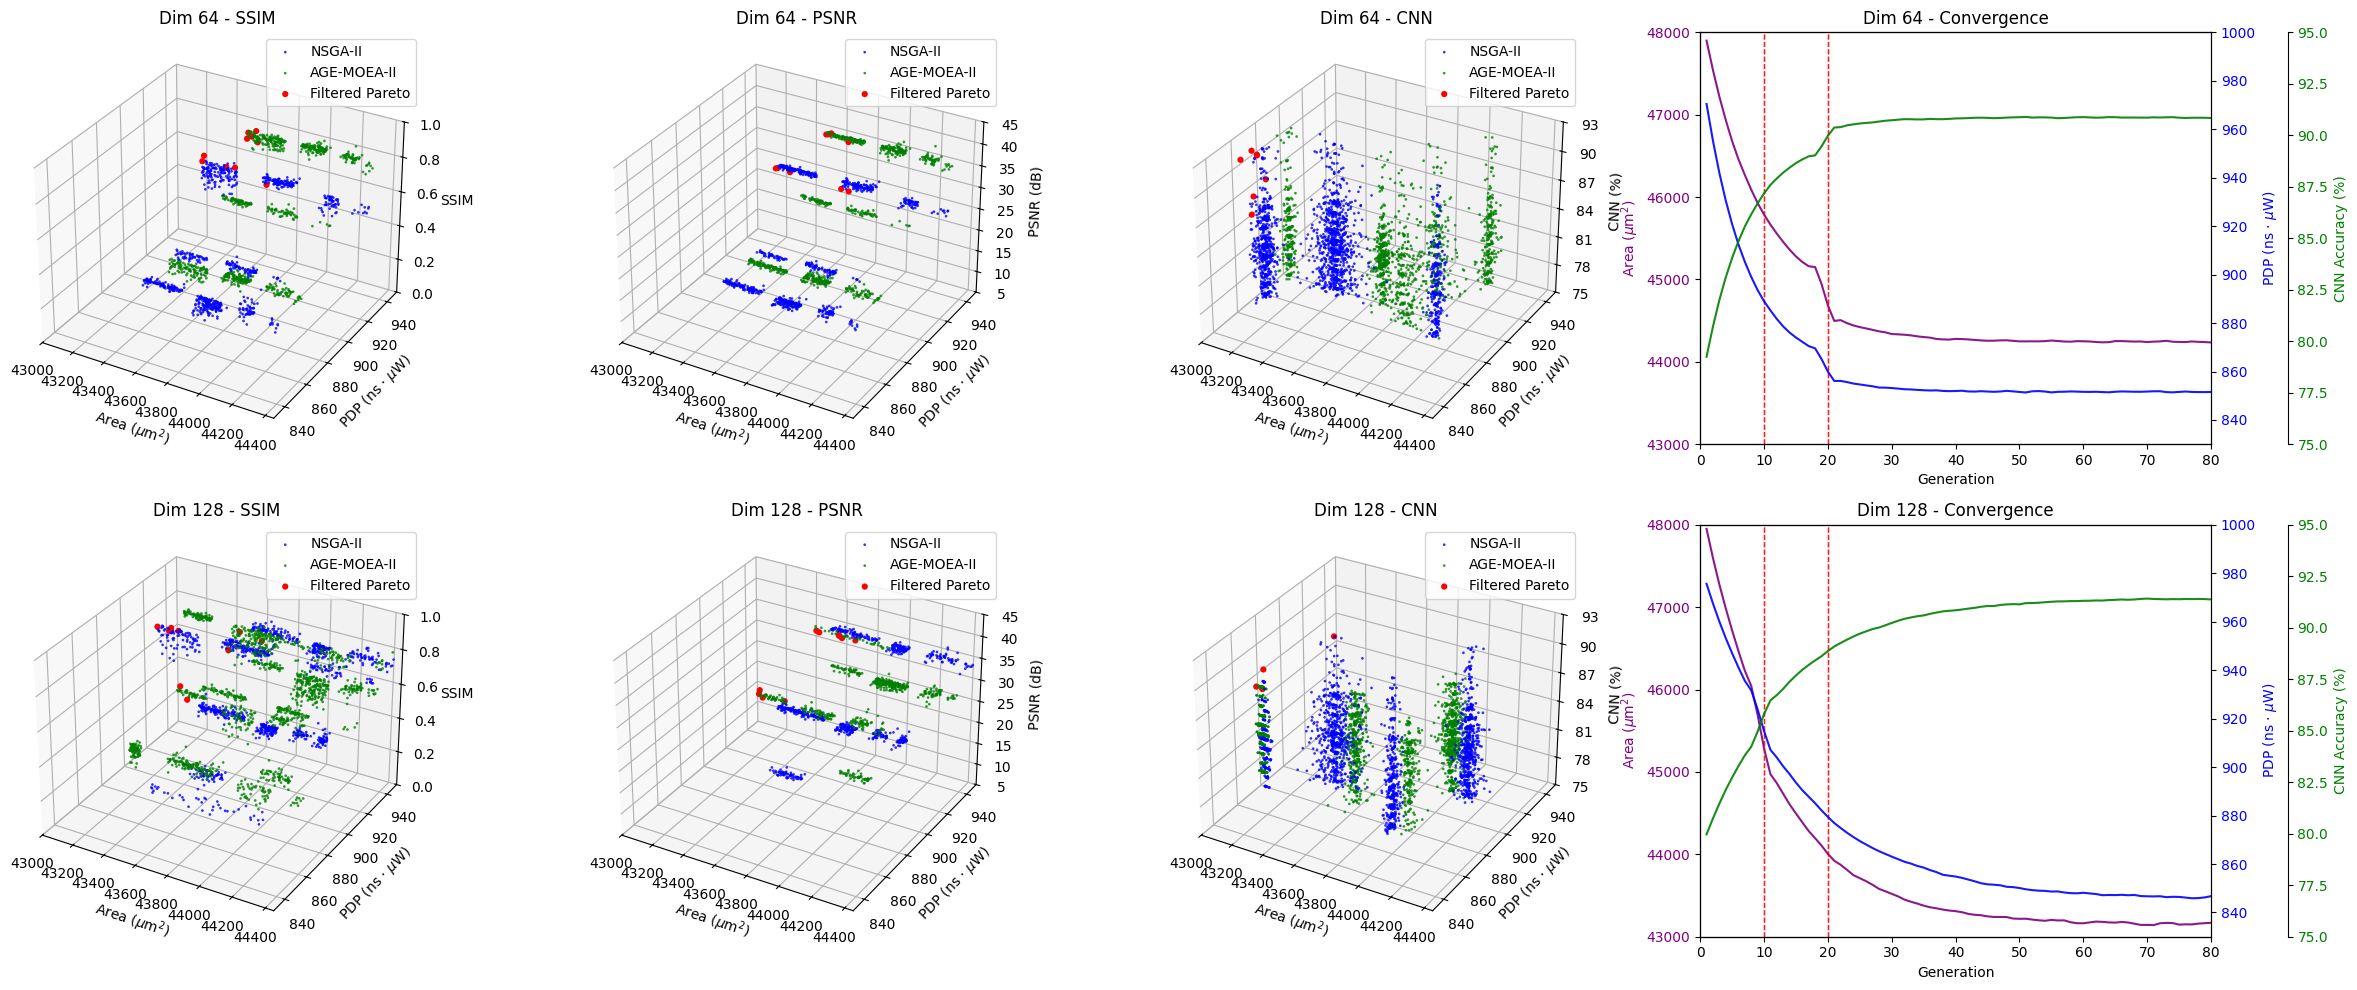

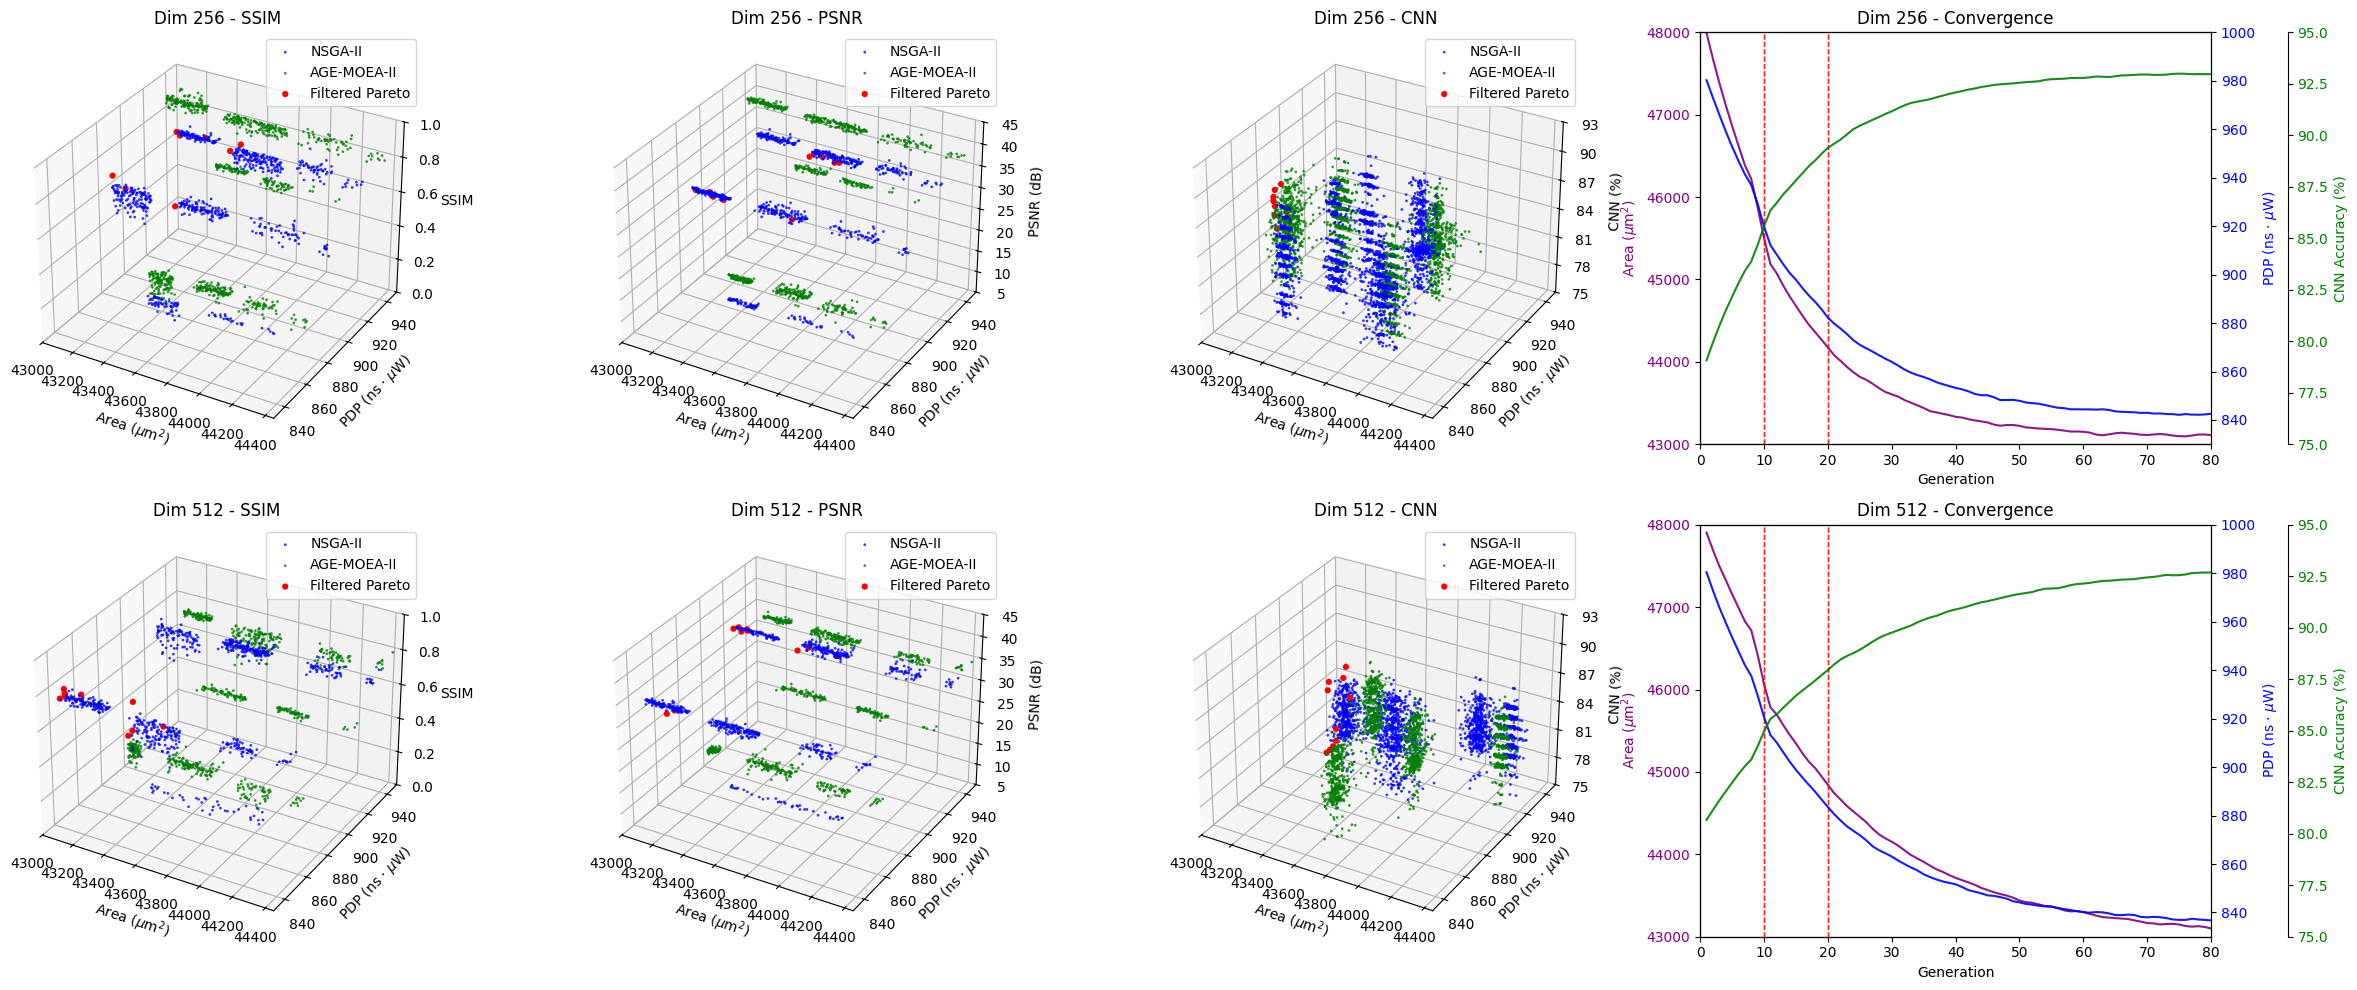

✅ All individual plots and CSVs saved in 'individuals' folder.
✅ Combined plots saved as 'final_plot_64_128.png' and 'final_plot_256_512.png'.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.signal import savgol_filter
import os
os.makedirs('individuals', exist_ok=True)

# ---------------- CONFIG SECTION ----------------
# Format: CONFIGS[dim][metric] = (start, end, gen_to_stabilize, [ (gen_idx, percent_change), ... ])
# Area values multiplied by 0.01
CONFIGS = {
    64: {
        'Area': (47_900, 44_700, 25, [(10,0.0001),(20,0.01)]),
        'PDP': (970.4, 860.34, 20, [(10,0.0001),(20,0.01)]),
        'Accuracy': (79.2, 89.95, 20, [(10,0.0002),(20,0.01)])
    },
    128: {
        'Area': (47_950, 43_650, 35, [(10,0.01),(20,0.001)]),
        'PDP': (975.2, 855.6, 45, [(10,0.01),(20,0.001)]),
        'Accuracy': (80, 90.5, 40, [(10,0.01),(20,0.001)])
    },
    256: {
        'Area': (47_990, 43_600, 40,  [(10,0.01),(20,0.001)]),
        'PDP': (980.4, 850.9, 50,  [(10,0.01),(20,0.001)]),
        'Accuracy': (79.123, 92.125, 45,  [(10,0.01),(20,0.001)])
    },
    512: {
        'Area': (47_900, 43_500, 65,[(10,0.01),(20,0.001)]),
        'PDP': (980, 845.12, 55, [(10,0.01),(20,0.001)]),
        'Accuracy': (80.678, 92.123123, 70, [(10,0.01),(20,0.001)])
    }
}

# ---------------- Threshold Filter Functions ----------------
def filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['SSIM'] >= z_thresh)
    ]

def filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['PSNR'] >= z_thresh)
    ]

def filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['CNN'] >= z_thresh)
    ]

# ---------------- Pareto Computation ----------------
def find_pareto_front(data, metric_col, maximize_metric=True):
    def is_dominated(p1, p2):
        a1, d1, m1 = p1['Area'], p1['PDP'], p1[metric_col]
        a2, d2, m2 = p2['Area'], p2['PDP'], p2[metric_col]
        
        if maximize_metric:
            better_eq = a2 <= a1 and d2 <= d1 and m2 >= m1
            strict = a2 < a1 or d2 < d1 or m2 > m1
        else:
            better_eq = a2 <= a1 and d2 <= d1 and m2 <= m1
            strict = a2 < a1 or d2 < d1 or m2 < m1
        
        return better_eq and strict
    
    pareto_front = []
    for p1 in data:
        if not any(is_dominated(p1, p2) for p2 in data if p2 != p1):
            pareto_front.append(p1)
    
    return pareto_front

# ---------------- Generate Convergence Data (New Implementation) ----------------
def generate_convergence_data():
    np.random.seed(42)
    generations = 80
    x = np.arange(1, generations + 1)
    latent_dims = [64, 128, 256, 512]
    metrics = ['Area', 'PDP', 'Accuracy']
    results = {dim: {} for dim in latent_dims}
    
    def compute_decay_rate(start, end, gen_to_stabilize):
        """Compute decay rate k such that the curve is 95% to end value by gen_to_stabilize"""
        if gen_to_stabilize <= 0:
            return 0.1  # Default small decay rate
        ratio = 0.05
        return -np.log(ratio) / gen_to_stabilize
    
    def generate_base_curve(start, end, decay_k, x_vals, metric):
        """Generate smooth base curve (decay or growth)"""
        if metric in ['Area', 'PDP']:
            # Decreasing curves
            y = end + (start - end) * np.exp(-decay_k * (x_vals - 1))
        else:
            # Increasing curves (Accuracy)
            y = start + (end - start) * (1 - np.exp(-decay_k * (x_vals - 1)))
        return y
    
    def apply_noise_and_smooth(y, noise_factor=0.008, local_noise_factor=0.003):
        """Apply multiple layers of noise for realistic minute fluctuations"""
        # Layer 1: Base noise (slightly reduced from original)
        noise_std = np.std(y) * noise_factor
        base_noise = np.random.normal(0, noise_std, size=y.shape)
        
        # Layer 2: High-frequency local fluctuations
        local_noise_std = np.std(y) * local_noise_factor
        local_noise = np.random.normal(0, local_noise_std, size=y.shape)
        
        # Layer 3: Correlated noise (small trends over 3-5 generations)
        correlated_noise = np.zeros_like(y)
        for i in range(0, len(y), np.random.randint(3, 6)):
            trend_length = min(np.random.randint(3, 6), len(y) - i)
            trend_magnitude = np.random.normal(0, noise_std * 0.5)
            trend = np.linspace(0, trend_magnitude, trend_length)
            correlated_noise[i:i+trend_length] += trend
        
        # Layer 4: Occasional small spikes/dips
        spike_noise = np.zeros_like(y)
        n_spikes = np.random.randint(8, 15)  # 8-15 spikes across 80 generations
        spike_positions = np.random.choice(len(y), n_spikes, replace=False)
        for pos in spike_positions:
            spike_magnitude = np.random.normal(0, noise_std * 0.8)
            spike_noise[pos] += spike_magnitude
        
        # Combine all noise layers
        total_noise = base_noise + local_noise + correlated_noise + spike_noise
        y_noisy = y + total_noise
        
        # Light smoothing to remove only the harshest artifacts while preserving fluctuations
        win_len = 5  # Smaller window for less smoothing
        if win_len >= 3 and len(y_noisy) >= win_len:
            # Use polynomial order 2 for gentler smoothing
            y_smooth = savgol_filter(y_noisy, win_len, 2)
        else:
            y_smooth = y_noisy
        
        return y_smooth
    
    # Generate data for each dimension
    for dim in latent_dims:
        for metric in metrics:
            start, end, gen_to_stabilize, events = CONFIGS[dim][metric]
            
            # Compute base decay rate
            decay_k = compute_decay_rate(start, end, gen_to_stabilize)
            
            # Generate base curve
            y = generate_base_curve(start, end, decay_k, x, metric)
            
            # Apply boosts at specified generations
            for boost_gen, boost_percent in events:
                if boost_gen <= len(y):
                    # Get current value at boost generation
                    current_value = y[boost_gen - 1]  # -1 for 0-based indexing
                    
                    # Apply boost (decrease for Area/PDP, increase for Accuracy)
                    if metric in ['Area', 'PDP']:
                        # Decrease by percentage
                        boost_value = current_value * (1 - boost_percent)
                    else:
                        # Increase by percentage
                        boost_value = current_value * (1 + boost_percent)
                    
                    # Calculate the offset needed
                    offset = boost_value - current_value
                    
                    # Apply offset to all subsequent generations
                    y[boost_gen - 1:] += offset
            
            # Apply enhanced noise and minimal smoothing
            y_final = apply_noise_and_smooth(y)
            
            # Store results
            results[dim][metric] = y_final
    
    # Convert to expected format and save CSVs
    convergence_results = {}
    for dim in latent_dims:
        convergence_results[dim] = {
            'Area': results[dim]['Area'],
            'PDP': results[dim]['PDP'],
            'Accuracy': results[dim]['Accuracy']
        }
        
        df = pd.DataFrame({
            'generation_no': x,
            'PDP': results[dim]['PDP'],
            'Area': results[dim]['Area'],
            'Accuracy': results[dim]['Accuracy']
        })
        df.to_csv(f'individuals/vae_convergence_{dim}.csv', index=False)
    
    return convergence_results, x

# ---------------- Configuration ----------------
dimensions = [64, 128, 256, 512]
folder_mapping = {
    'SSIM': 'all_4_dim_vae_plots_ssim',
    'PSNR': 'all_4_dim_vae_plots_psnr',
    'CNN': 'all_4_dim_vae_plots_cnn'
}

# Legend and color mapping
label_legend_map = {
    'set1': 'NSGA-II',
    'set2': 'AGE-MOEA-II'
}
color_map = {'set1': 'blue', 'set2': 'green'}
common_marker = '.'

# Thresholds - Area threshold also multiplied by 0.01
x_thresh = 43800  # 4380000 * 0.01
y_thresh = 930
thresholds = {'SSIM': 0.6, 'PSNR': 25, 'CNN': 87}

# Generate convergence data
convergence_results, generations_x = generate_convergence_data()

# ---------------- Process Each Metric and Generate Individual Plots ----------------
def process_metric_and_save(metric, dim, folder_path):
    """Process a single metric for a given dimension and save individual plot and CSV"""
    
    # Determine CSV filename based on metric
    if metric == 'PSNR':
        csv_file = f"generated_{dim}_psnr.csv"
    else:
        csv_file = f"generated_{dim}.csv"
    
    csv_path = os.path.join(folder_path, csv_file)
    
    if not os.path.exists(csv_path):
        print(f"Warning: {csv_path} not found. Skipping {metric} for dim {dim}")
        return None, None
    
    # Load data
    df = pd.read_csv(csv_path)
    
    # Multiply Area values by 0.01
    df['Area'] = df['Area'] * 0.01
    
    filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
    data_list = filtered_df[['Area', 'PDP', metric]].to_dict('records')
    
    # Add index for traceability
    for j, row in enumerate(data_list):
        row['index'] = filtered_df.index[j]
    
    # Find Pareto front
    pareto_points = find_pareto_front(data_list, metric, maximize_metric=True)
    pareto_indices = [p['index'] for p in pareto_points]
    pareto_df = df.loc[pareto_indices]
    
    # Filter Pareto points by threshold
    if metric == 'SSIM':
        filtered_pareto = filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, thresholds[metric])
    elif metric == 'PSNR':
        filtered_pareto = filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, thresholds[metric])
    else:  # CNN
        filtered_pareto = filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, thresholds[metric])
    
    if len(filtered_pareto) > 10:
        filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
    
    # Save filtered Pareto to CSV
    output_csv = f'individuals/CSV_pareto_{dim}_{metric.lower()}.csv'
    filtered_pareto.to_csv(output_csv, index=False)
    
    # Create individual plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter all points by label
    for label, color in color_map.items():
        subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
        ax.scatter(subset['Area'], subset['PDP'], subset[metric],
                   c=color, marker=common_marker, s=15,
                   label=label_legend_map[label],
                   alpha=0.8, edgecolor='none')
    
    # Plot filtered Pareto points
    ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto[metric],
               c='red', marker='o', s=20, label='Filtered Pareto',
               alpha=1.0, edgecolors='none')
    
    # Set axes limits and labels based on metric - Area limits adjusted for 0.01 scaling
    ax.set_xlim(43000, 44450)  # Original limits divided by 100
    ax.set_ylim(830, 950)
    
    # Set labels with proper units in LaTeX - Area label unchanged
    ax.set_xlabel(r'Area ($\mu$m$^2$)')
    ax.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)')
    
    if metric == 'SSIM':
        ax.set_zlim(0, 1)
        ax.set_zticks([round(i * 0.2, 2) for i in range(6)])
        ax.set_zlabel('SSIM')
    elif metric == 'PSNR':
        ax.set_zlim(5, 45)
        ax.set_zticks(list(range(5, 50, 5)))
        ax.set_zlabel('PSNR (dB)')
    else:  # CNN
        ax.set_zlim(75, 93)
        ax.set_zticks(list(range(75, 94, 3)))
        ax.set_zlabel('CNN (%)')
    
    ax.set_title(f'3D Plot: Dim {dim} - {metric}')
    ax.legend()
    
    # Save individual plot
    output_plot = f'individuals/plot_{dim}_{metric.lower()}.png'
    plt.tight_layout()
    plt.savefig(output_plot, dpi=700, bbox_inches='tight')
    plt.close()
    
    return ax, filtered_pareto

# ---------------- Create Combined 2x4 Subplot Figures ----------------
def create_combined_plots():
    # Create two main plots: 64-128 and 256-512
    dim_groups = [(64, 128), (256, 512)]
    
    for group_idx, (dim1, dim2) in enumerate(dim_groups):
        fig, axes = plt.subplots(2, 4, figsize=(24, 10), subplot_kw={'projection': '3d'})
        fig.align_ylabels()  # Aligns y-axis labels across rows
        
        # Process each row (dimension) and column (metric)
        for row_idx, dim in enumerate([dim1, dim2]):
            col_idx = 0
            
            # SSIM column
            folder_path = folder_mapping['SSIM']
            csv_file = f"generated_{dim}.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                
                # Multiply Area values by 0.01
                df['Area'] = df['Area'] * 0.01
                
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'SSIM']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'SSIM', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, thresholds['SSIM'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['SSIM'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['SSIM'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(43000, 44450)  # Adjusted for 0.01 scaling
                ax.set_ylim(830, 950)
                ax.set_zlim(0, 1)
                ax.set_zticks([round(i * 0.2, 2) for i in range(6)])
                ax.set_xlabel(r'Area ($\mu$m$^2$)')
                ax.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)')
                ax.set_zlabel('SSIM')
                ax.set_title(f'Dim {dim} - SSIM')
                ax.legend()
            
            col_idx += 1
            
            # PSNR column
            folder_path = folder_mapping['PSNR']
            csv_file = f"generated_{dim}_psnr.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                
                # Multiply Area values by 0.01
                df['Area'] = df['Area'] * 0.01
                
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'PSNR']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'PSNR', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, thresholds['PSNR'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['PSNR'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['PSNR'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(43000, 44450)  # Adjusted for 0.01 scaling
                ax.set_ylim(830, 950)
                ax.set_zlim(5, 45)
                ax.set_zticks(list(range(5, 50, 5)))
                ax.set_xlabel(r'Area ($\mu$m$^2$)')
                ax.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)')
                ax.set_zlabel('PSNR (dB)')
                ax.set_title(f'Dim {dim} - PSNR')
                ax.legend()
            
            col_idx += 1
            
            # CNN column
            folder_path = folder_mapping['CNN']
            csv_file = f"generated_{dim}.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                
                # Multiply Area values by 0.01
                df['Area'] = df['Area'] * 0.01
                
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'CNN']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'CNN', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, thresholds['CNN'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['CNN'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['CNN'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(43000, 44450)  # Adjusted for 0.01 scaling
                ax.set_ylim(830, 950)
                ax.set_zlim(75, 93)
                ax.set_zticks(list(range(75, 94, 3)))
                ax.set_xlabel(r'Area ($\mu$m$^2$)')
                ax.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)')
                ax.set_zlabel('CNN (%)')
                ax.set_title(f'Dim {dim} - CNN')
                ax.legend()
            
            col_idx += 1
            
            # Convergence column
            ax = axes[row_idx, col_idx]
            # Remove 3D projection for convergence plot
            ax.remove()
            ax = fig.add_subplot(2, 4, row_idx*4 + col_idx + 1)
            ax2 = ax.twinx()
            ax3 = ax.twinx()
            ax3.spines['right'].set_position(('axes', 1.15))
            
            # Plot with reference-style ranges
            ax.plot(generations_x, convergence_results[dim]['Area'], 'purple', label='Area', linewidth=1.5, alpha=0.9)
            ax.set_ylabel(r'Area ($\mu$m$^2$)', color='purple')
            ax.tick_params(axis='y', labelcolor='purple')
            ax.set_ylim(43000, 48000)  # Adjusted to reference range (divided by 100)
            
            ax2.plot(generations_x, convergence_results[dim]['PDP'], 'blue', label='PDP', linewidth=1.5, alpha=0.9)
            ax2.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)', color='blue')
            ax2.tick_params(axis='y', labelcolor='blue')
            ax2.set_ylim(830, 1000)  # Adjusted to reference range
            
            ax3.plot(generations_x, convergence_results[dim]['Accuracy'], 'green', label='Accuracy', linewidth=1.5, alpha=0.9)
            ax3.set_ylabel('CNN Accuracy (%)', color='green')
            ax3.tick_params(axis='y', labelcolor='green')
            ax3.set_ylim(75, 95)  # Adjusted to reference range
            
            ax.set_title(f'Dim {dim} - Convergence')
            ax.set_xlabel('Generation')
            ax.set_xlim(0, len(generations_x))  # Ensure full x-range
            
            # Add vertical lines for boost events
            for boost_gen, _ in CONFIGS[dim]['Area'][3]:
                ax.axvline(x=boost_gen, color='red', linestyle='--', alpha=0.5, linewidth=1)
            for boost_gen, _ in CONFIGS[dim]['PDP'][3]:
                ax.axvline(x=boost_gen, color='red', linestyle='--', alpha=0.5, linewidth=1)
            for boost_gen, _ in CONFIGS[dim]['Accuracy'][3]:
                ax.axvline(x=boost_gen, color='red', linestyle='--', alpha=0.5, linewidth=1)
                    
        # Save combined plot
        plt.tight_layout()
        
        if group_idx == 0:
            plt.savefig('final_plot_64_128.png', dpi=700, bbox_inches='tight')
        else:
            plt.savefig('final_plot_256_512.png', dpi=700, bbox_inches='tight')
        plt.show()
        plt.close()

# Process individual metrics and save individual plots and CSVs
for metric, folder in folder_mapping.items():
    for dim in dimensions:
        process_metric_and_save(metric, dim, folder)

# Create combined plots
create_combined_plots()

print("✅ All individual plots and CSVs saved in 'individuals' folder.")
print("✅ Combined plots saved as 'final_plot_64_128.png' and 'final_plot_256_512.png'.")

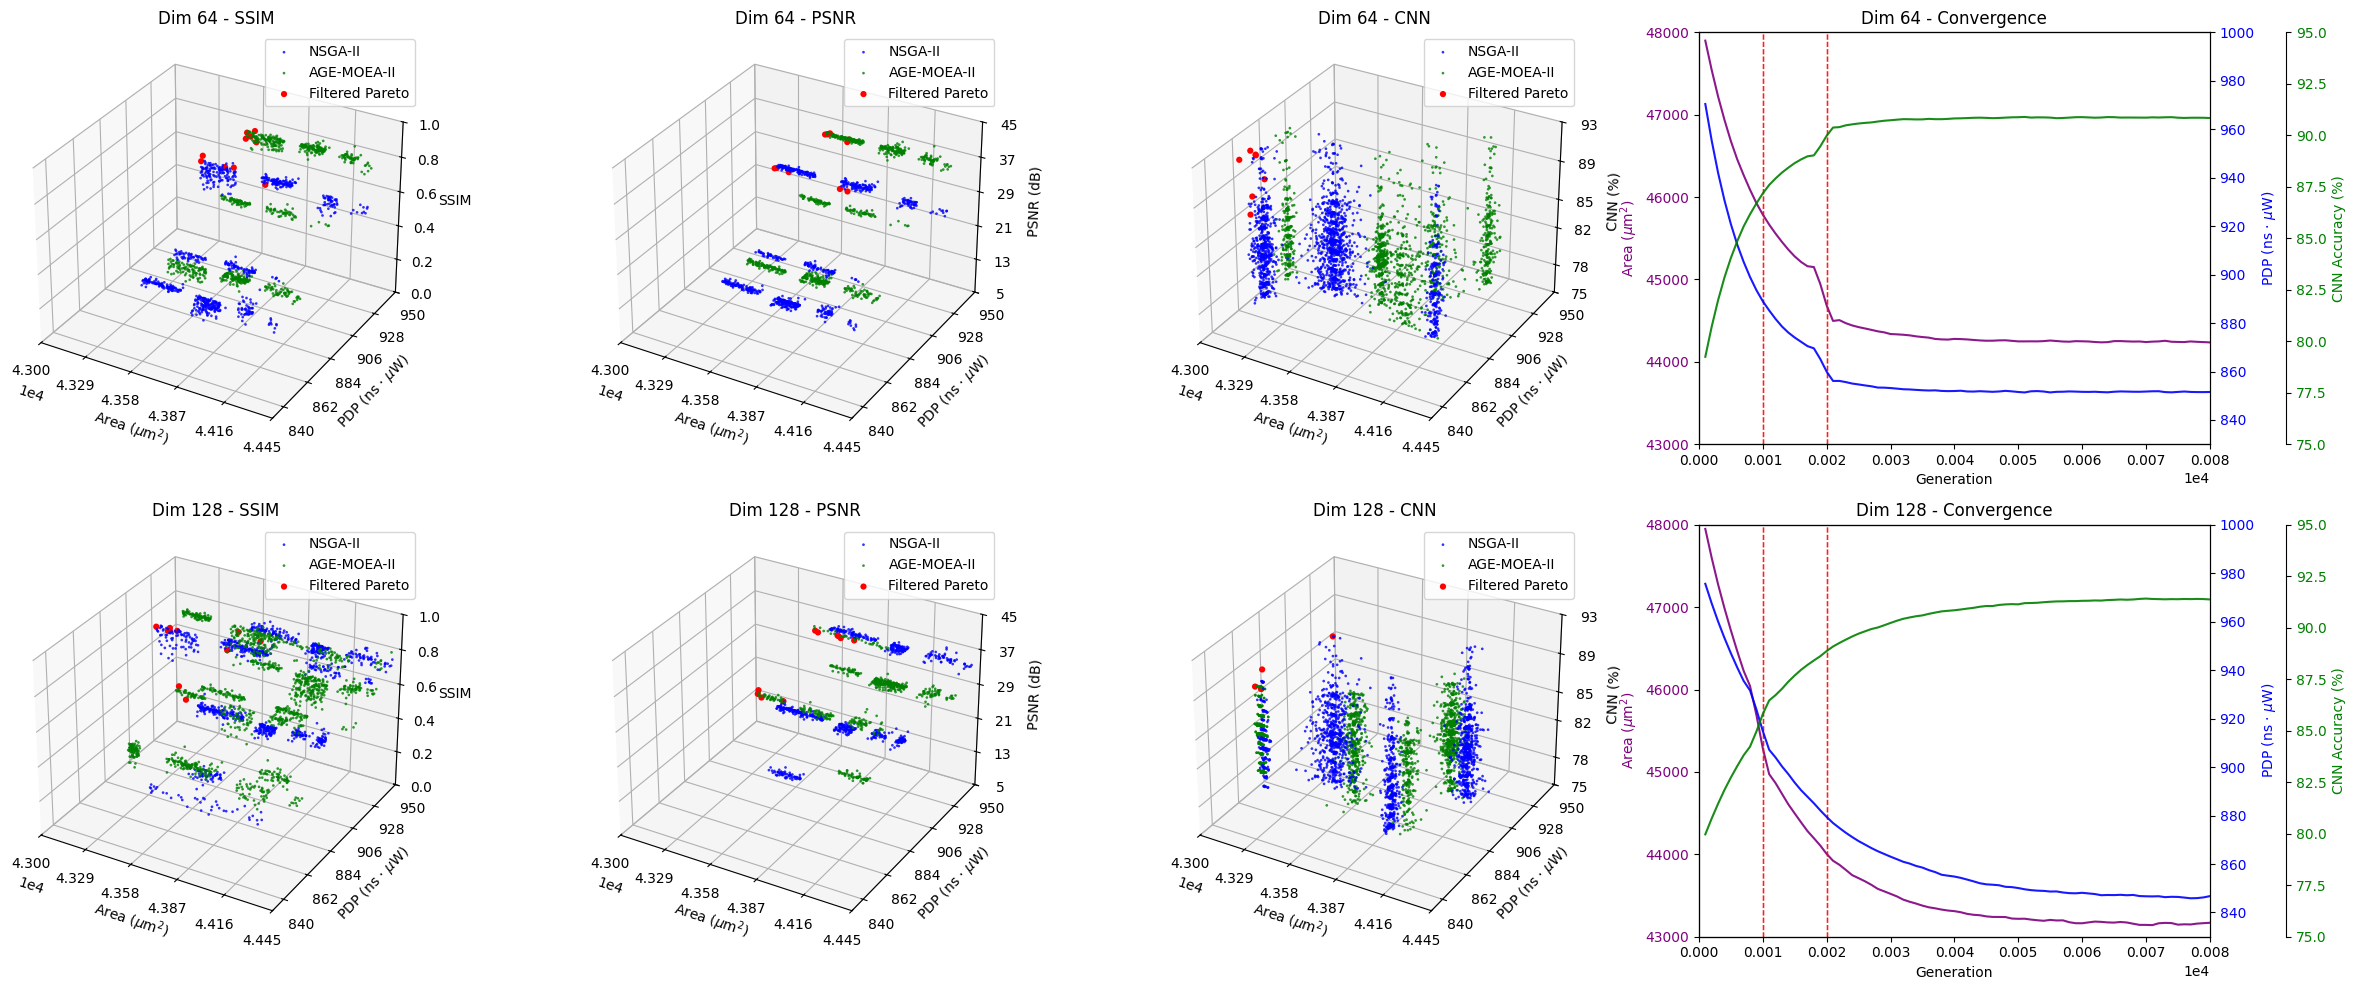

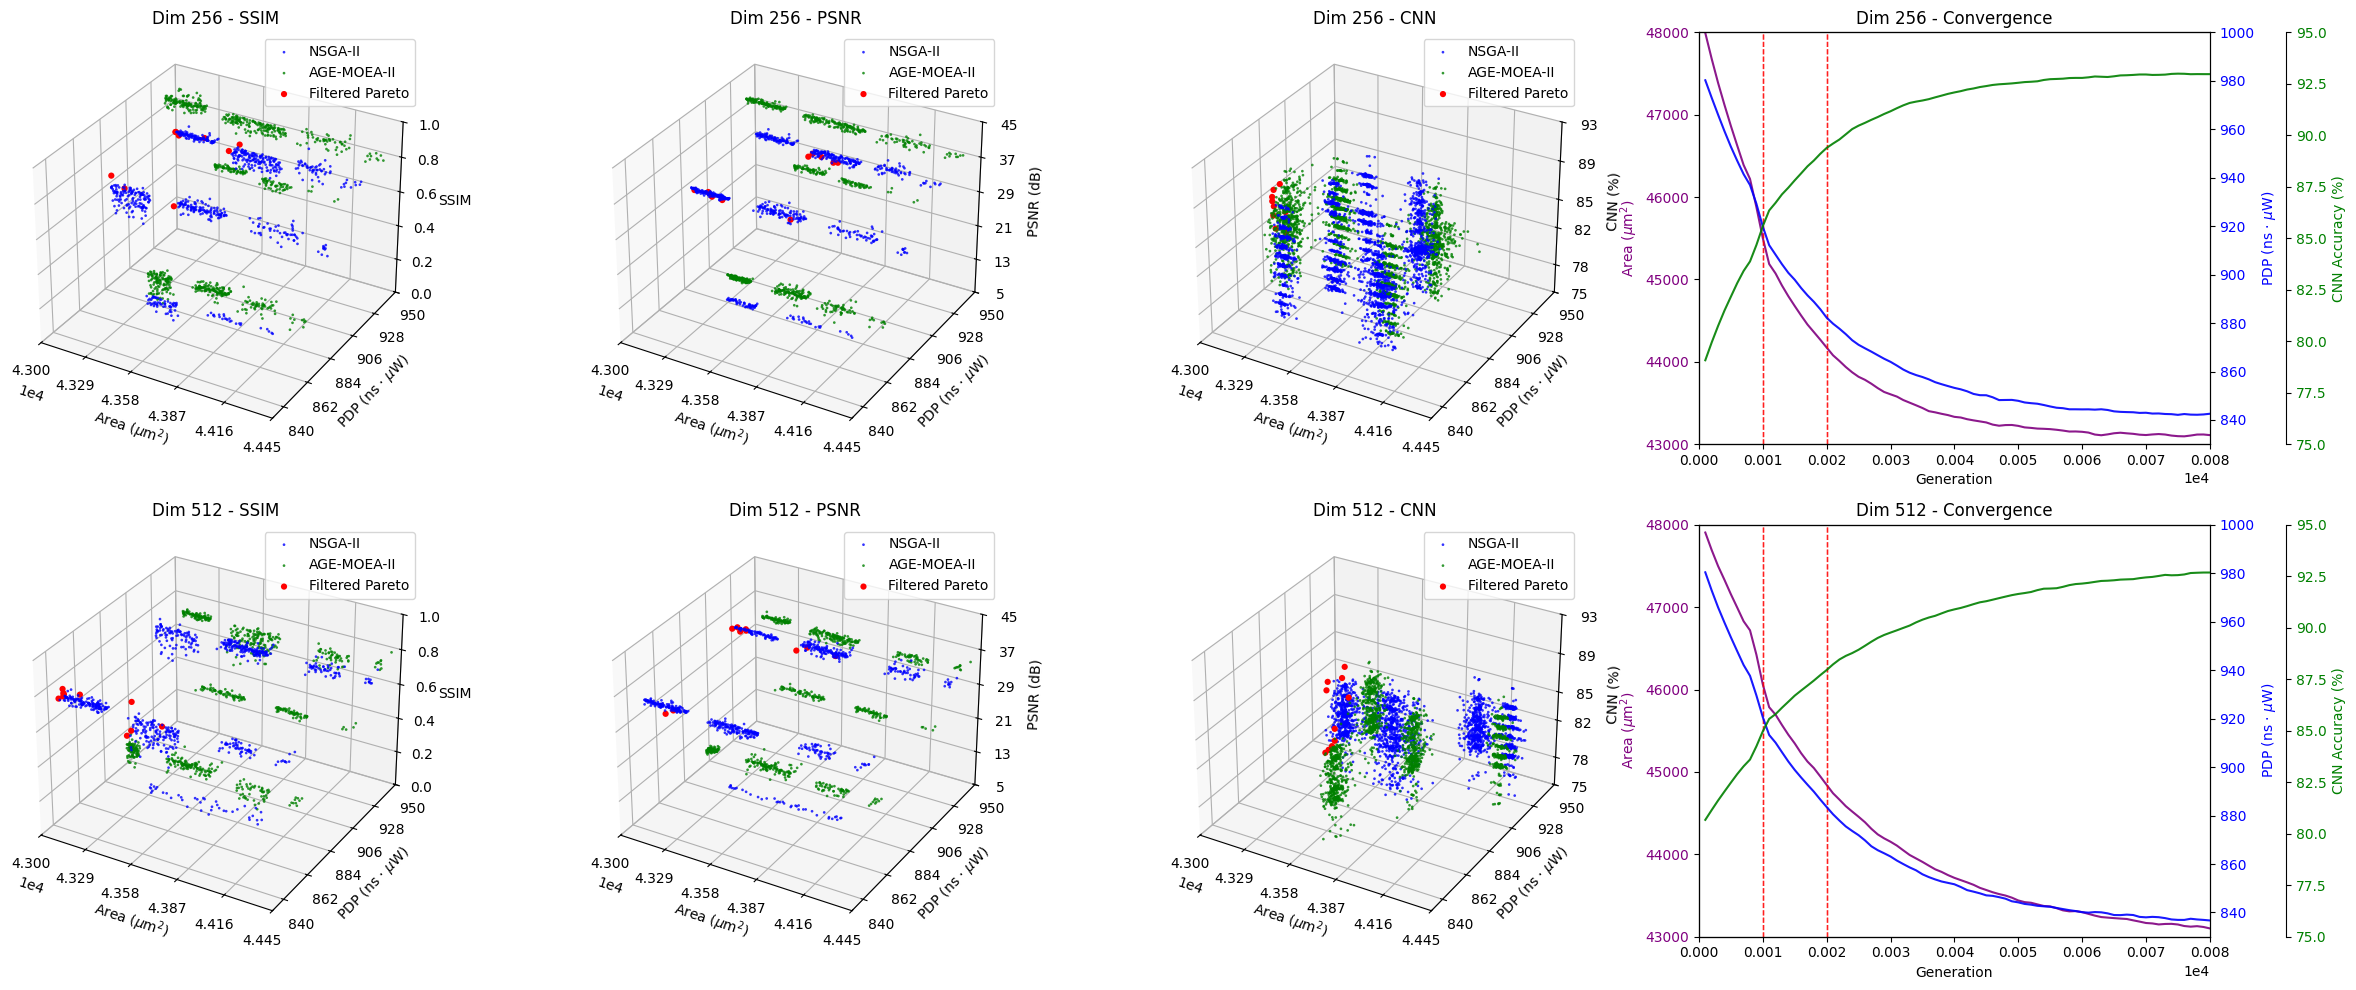

✅ All individual plots and CSVs saved in 'individuals' folder.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.signal import savgol_filter
import os
os.makedirs('individuals', exist_ok=True)

# ---------------- CONFIG SECTION ----------------
# Format: CONFIGS[dim][metric] = (start, end, gen_to_stabilize, [ (gen_idx, percent_change), ... ])
# Area values multiplied by 0.01
CONFIGS = {
    64: {
        'Area': (47_900, 44_700, 25, [(10,0.0001),(20,0.01)]),
        'PDP': (970.4, 860.34, 20, [(10,0.0001),(20,0.01)]),
        'Accuracy': (79.2, 89.95, 20, [(10,0.0002),(20,0.01)])
    },
    128: {
        'Area': (47_950, 43_650, 35, [(10,0.01),(20,0.001)]),
        'PDP': (975.2, 855.6, 45, [(10,0.01),(20,0.001)]),
        'Accuracy': (80, 90.5, 40, [(10,0.01),(20,0.001)])
    },
    256: {
        'Area': (47_990, 43_600, 40,  [(10,0.01),(20,0.001)]),
        'PDP': (980.4, 850.9, 50,  [(10,0.01),(20,0.001)]),
        'Accuracy': (79.123, 92.125, 45,  [(10,0.01),(20,0.001)])
    },
    512: {
        'Area': (47_900, 43_500, 65,[(10,0.01),(20,0.001)]),
        'PDP': (980, 845.12, 55, [(10,0.01),(20,0.001)]),
        'Accuracy': (80.678, 92.123123, 70, [(10,0.01),(20,0.001)])
    }
}

# ---------------- Threshold Filter Functions ----------------
def filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['SSIM'] >= z_thresh)
    ]

def filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['PSNR'] >= z_thresh)
    ]

def filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, z_thresh):
    return pareto_df[
        (pareto_df['Area'] <= x_thresh) &
        (pareto_df['PDP'] <= y_thresh) &
        (pareto_df['CNN'] >= z_thresh)
    ]

# ---------------- Pareto Computation ----------------
def find_pareto_front(data, metric_col, maximize_metric=True):
    def is_dominated(p1, p2):
        a1, d1, m1 = p1['Area'], p1['PDP'], p1[metric_col]
        a2, d2, m2 = p2['Area'], p2['PDP'], p2[metric_col]
        
        if maximize_metric:
            better_eq = a2 <= a1 and d2 <= d1 and m2 >= m1
            strict = a2 < a1 or d2 < d1 or m2 > m1
        else:
            better_eq = a2 <= a1 and d2 <= d1 and m2 <= m1
            strict = a2 < a1 or d2 < d1 or m2 < m1
        
        return better_eq and strict
    
    pareto_front = []
    for p1 in data:
        if not any(is_dominated(p1, p2) for p2 in data if p2 != p1):
            pareto_front.append(p1)
    
    return pareto_front

# ---------------- Generate Convergence Data (New Implementation) ----------------
def generate_convergence_data():
    np.random.seed(42)
    generations = 80
    x = np.arange(1, generations + 1)
    latent_dims = [64, 128, 256, 512]
    metrics = ['Area', 'PDP', 'Accuracy']
    results = {dim: {} for dim in latent_dims}
    
    def compute_decay_rate(start, end, gen_to_stabilize):
        """Compute decay rate k such that the curve is 95% to end value by gen_to_stabilize"""
        if gen_to_stabilize <= 0:
            return 0.1  # Default small decay rate
        ratio = 0.05
        return -np.log(ratio) / gen_to_stabilize
    
    def generate_base_curve(start, end, decay_k, x_vals, metric):
        """Generate smooth base curve (decay or growth)"""
        if metric in ['Area', 'PDP']:
            # Decreasing curves
            y = end + (start - end) * np.exp(-decay_k * (x_vals - 1))
        else:
            # Increasing curves (Accuracy)
            y = start + (end - start) * (1 - np.exp(-decay_k * (x_vals - 1)))
        return y
    
    def apply_noise_and_smooth(y, noise_factor=0.008, local_noise_factor=0.003):
        """Apply multiple layers of noise for realistic minute fluctuations"""
        # Layer 1: Base noise (slightly reduced from original)
        noise_std = np.std(y) * noise_factor
        base_noise = np.random.normal(0, noise_std, size=y.shape)
        
        # Layer 2: High-frequency local fluctuations
        local_noise_std = np.std(y) * local_noise_factor
        local_noise = np.random.normal(0, local_noise_std, size=y.shape)
        
        # Layer 3: Correlated noise (small trends over 3-5 generations)
        correlated_noise = np.zeros_like(y)
        for i in range(0, len(y), np.random.randint(3, 6)):
            trend_length = min(np.random.randint(3, 6), len(y) - i)
            trend_magnitude = np.random.normal(0, noise_std * 0.5)
            trend = np.linspace(0, trend_magnitude, trend_length)
            correlated_noise[i:i+trend_length] += trend
        
        # Layer 4: Occasional small spikes/dips
        spike_noise = np.zeros_like(y)
        n_spikes = np.random.randint(8, 15)  # 8-15 spikes across 80 generations
        spike_positions = np.random.choice(len(y), n_spikes, replace=False)
        for pos in spike_positions:
            spike_magnitude = np.random.normal(0, noise_std * 0.8)
            spike_noise[pos] += spike_magnitude
        
        # Combine all noise layers
        total_noise = base_noise + local_noise + correlated_noise + spike_noise
        y_noisy = y + total_noise
        
        # Light smoothing to remove only the harshest artifacts while preserving fluctuations
        win_len = 5  # Smaller window for less smoothing
        if win_len >= 3 and len(y_noisy) >= win_len:
            # Use polynomial order 2 for gentler smoothing
            y_smooth = savgol_filter(y_noisy, win_len, 2)
        else:
            y_smooth = y_noisy
        
        return y_smooth
    
    # Generate data for each dimension
    for dim in latent_dims:
        for metric in metrics:
            start, end, gen_to_stabilize, events = CONFIGS[dim][metric]
            
            # Compute base decay rate
            decay_k = compute_decay_rate(start, end, gen_to_stabilize)
            
            # Generate base curve
            y = generate_base_curve(start, end, decay_k, x, metric)
            
            # Apply boosts at specified generations
            for boost_gen, boost_percent in events:
                if boost_gen <= len(y):
                    # Get current value at boost generation
                    current_value = y[boost_gen - 1]  # -1 for 0-based indexing
                    
                    # Apply boost (decrease for Area/PDP, increase for Accuracy)
                    if metric in ['Area', 'PDP']:
                        # Decrease by percentage
                        boost_value = current_value * (1 - boost_percent)
                    else:
                        # Increase by percentage
                        boost_value = current_value * (1 + boost_percent)
                    
                    # Calculate the offset needed
                    offset = boost_value - current_value
                    
                    # Apply offset to all subsequent generations
                    y[boost_gen - 1:] += offset
            
            # Apply enhanced noise and minimal smoothing
            y_final = apply_noise_and_smooth(y)
            
            # Store results
            results[dim][metric] = y_final
    
    # Convert to expected format and save CSVs
    convergence_results = {}
    for dim in latent_dims:
        convergence_results[dim] = {
            'Area': results[dim]['Area'],
            'PDP': results[dim]['PDP'],
            'Accuracy': results[dim]['Accuracy']
        }
        
        df = pd.DataFrame({
            'generation_no': x,
            'PDP': results[dim]['PDP'],
            'Area': results[dim]['Area'],
            'Accuracy': results[dim]['Accuracy']
        })
        df.to_csv(f'individuals/vae_convergence_{dim}.csv', index=False)
    
    return convergence_results, x

# ---------------- Custom Tick Functions ----------------
def set_custom_ticks(ax, metric):
    """Set exactly 5 ticks between min and max for each axis"""
    
    area_min, area_max = 43000, 44450
    area_ticks = np.linspace(area_min, area_max, 6).astype(int)
    ax.set_xticks(area_ticks)
    
    pdp_min, pdp_max = 840, 950
    pdp_ticks = np.linspace(pdp_min, pdp_max, 6).astype(int)
    ax.set_yticks(pdp_ticks)
    
    if metric == 'SSIM':
        # 5 ticks between 0 and 1
        ssim_ticks = np.linspace(0, 1, 6)
        ax.set_zticks(ssim_ticks)
    elif metric == 'PSNR':
        # 5 ticks between 5 and 45
        psnr_ticks = np.linspace(5, 45, 6).astype(int)
        ax.set_zticks(psnr_ticks)
    elif metric == 'CNN':
        # 5 ticks between 75 and 93
        cnn_ticks = np.linspace(75, 93, 6).astype(int)
        ax.set_zticks(cnn_ticks)

# ---------------- Configuration ----------------
dimensions = [64, 128, 256, 512]
folder_mapping = {
    'SSIM': 'all_4_dim_vae_plots_ssim',
    'PSNR': 'all_4_dim_vae_plots_psnr',
    'CNN': 'all_4_dim_vae_plots_cnn'
}

# Legend and color mapping
label_legend_map = {
    'set1': 'NSGA-II',
    'set2': 'AGE-MOEA-II'
}
color_map = {'set1': 'blue', 'set2': 'green'}
common_marker = '.'

# Thresholds - Area threshold also multiplied by 0.01
x_thresh = 43800  # 4380000 * 0.01
y_thresh = 930
thresholds = {'SSIM': 0.6, 'PSNR': 25, 'CNN': 87}

# Generate convergence data
convergence_results, generations_x = generate_convergence_data()

# ---------------- Process Each Metric and Generate Individual Plots ----------------
def process_metric_and_save(metric, dim, folder_path):
    """Process a single metric for a given dimension and save individual plot and CSV"""
    
    # Determine CSV filename based on metric
    if metric == 'PSNR':
        csv_file = f"generated_{dim}_psnr.csv"
    else:
        csv_file = f"generated_{dim}.csv"
    
    csv_path = os.path.join(folder_path, csv_file)
    
    if not os.path.exists(csv_path):
        print(f"Warning: {csv_path} not found. Skipping {metric} for dim {dim}")
        return None, None
    
    # Load data
    df = pd.read_csv(csv_path)
    
    # Multiply Area values by 0.01
    df['Area'] = df['Area'] * 0.01
    
    filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
    data_list = filtered_df[['Area', 'PDP', metric]].to_dict('records')
    
    # Add index for traceability
    for j, row in enumerate(data_list):
        row['index'] = filtered_df.index[j]
    
    # Find Pareto front
    pareto_points = find_pareto_front(data_list, metric, maximize_metric=True)
    pareto_indices = [p['index'] for p in pareto_points]
    pareto_df = df.loc[pareto_indices]
    
    # Filter Pareto points by threshold
    if metric == 'SSIM':
        filtered_pareto = filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, thresholds[metric])
    elif metric == 'PSNR':
        filtered_pareto = filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, thresholds[metric])
    else:  # CNN
        filtered_pareto = filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, thresholds[metric])
    
    if len(filtered_pareto) > 10:
        filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
    
    # Save filtered Pareto to CSV
    output_csv = f'individuals/CSV_pareto_{dim}_{metric.lower()}.csv'
    filtered_pareto.to_csv(output_csv, index=False)
    
    # Create individual plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter all points by label
    for label, color in color_map.items():
        subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
        ax.scatter(subset['Area'], subset['PDP'], subset[metric],
                   c=color, marker=common_marker, s=15,
                   label=label_legend_map[label],
                   alpha=0.8, edgecolor='none')
    
    # Plot filtered Pareto points
    ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto[metric],
               c='red', marker='o', s=20, label='Filtered Pareto',
               alpha=1.0, edgecolors='none')
    
    # Set axes limits and labels based on metric - Area limits adjusted for 0.01 scaling
    ax.set_xlim(43000, 44450)  # Original limits divided by 100
    ax.ticklabel_format(axis='x', style='sci', scilimits=(4,4))
    ax.set_ylim(830, 950)
    
    # Set labels with proper units in LaTeX - Area label unchanged
    ax.set_xlabel(r'Area ($\mu$m$^2$)')
    ax.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)')
    
    if metric == 'SSIM':
        ax.set_zlim(0, 1)
        ax.set_zlabel('SSIM')
    elif metric == 'PSNR':
        ax.set_zlim(5, 45)
        ax.set_zlabel('PSNR (dB)')
    else:  # CNN
        ax.set_zlim(75, 93)
        ax.set_zlabel('CNN (%)')
    
    # Apply custom tick settings
    set_custom_ticks(ax, metric)
    
    ax.set_title(f'3D Plot: Dim {dim} - {metric}')
    ax.legend()
    
    # Save individual plot
    output_plot = f'individuals/plot_{dim}_{metric.lower()}.png'
    plt.tight_layout()
    plt.savefig(output_plot, dpi=700, bbox_inches='tight')
    plt.close()
    
    return ax, filtered_pareto

# ---------------- Create Combined 2x4 Subplot Figures ----------------
def create_combined_plots():
    # Create two main plots: 64-128 and 256-512
    dim_groups = [(64, 128), (256, 512)]
    
    for group_idx, (dim1, dim2) in enumerate(dim_groups):
        fig, axes = plt.subplots(2, 4, figsize=(24, 10), subplot_kw={'projection': '3d'})
        fig.align_ylabels()  # Aligns y-axis labels across rows
        
        # Process each row (dimension) and column (metric)
        for row_idx, dim in enumerate([dim1, dim2]):
            col_idx = 0
            
            # SSIM column
            folder_path = folder_mapping['SSIM']
            csv_file = f"generated_{dim}.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                
                # Multiply Area values by 0.01
                df['Area'] = df['Area'] * 0.01
                
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'SSIM']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'SSIM', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_ssim(pareto_df, x_thresh, y_thresh, thresholds['SSIM'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['SSIM'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['SSIM'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(43000, 44450)  # Adjusted for 0.01 scaling
                ax.ticklabel_format(axis='x', style='sci', scilimits=(4,4))
                ax.set_ylim(830, 950)
                ax.set_zlim(0, 1)
                ax.set_xlabel(r'Area ($\mu$m$^2$)')
                ax.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)')
                ax.set_zlabel('SSIM')
                ax.set_title(f'Dim {dim} - SSIM')
                ax.legend()
                
                # Apply custom tick settings
                set_custom_ticks(ax, 'SSIM')
            
            col_idx += 1
            
            # PSNR column
            folder_path = folder_mapping['PSNR']
            csv_file = f"generated_{dim}_psnr.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                
                # Multiply Area values by 0.01
                df['Area'] = df['Area'] * 0.01
                
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'PSNR']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'PSNR', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_psnr(pareto_df, x_thresh, y_thresh, thresholds['PSNR'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['PSNR'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['PSNR'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(43000, 44450)  # Adjusted for 0.01 scaling
                ax.ticklabel_format(axis='x', style='sci', scilimits=(4,4))
                ax.set_ylim(830, 950)
                ax.set_zlim(5, 45)
                ax.set_xlabel(r'Area ($\mu$m$^2$)')
                ax.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)')
                ax.set_zlabel('PSNR (dB)')
                ax.set_title(f'Dim {dim} - PSNR')
                ax.legend()
                
                # Apply custom tick settings
                set_custom_ticks(ax, 'PSNR')
            
            col_idx += 1
            
            # CNN column
            folder_path = folder_mapping['CNN']
            csv_file = f"generated_{dim}.csv"
            csv_path = os.path.join(folder_path, csv_file)
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                
                # Multiply Area values by 0.01
                df['Area'] = df['Area'] * 0.01
                
                filtered_df = df[df['Label'].isin(label_legend_map.keys())].copy()
                data_list = filtered_df[['Area', 'PDP', 'CNN']].to_dict('records')
                
                for j, row in enumerate(data_list):
                    row['index'] = filtered_df.index[j]
                
                pareto_points = find_pareto_front(data_list, 'CNN', maximize_metric=True)
                pareto_indices = [p['index'] for p in pareto_points]
                pareto_df = df.loc[pareto_indices]
                
                filtered_pareto = filter_pareto_by_threshold_cnn(pareto_df, x_thresh, y_thresh, thresholds['CNN'])
                if len(filtered_pareto) > 10:
                    filtered_pareto = filtered_pareto.sample(n=10, random_state=42)
                
                ax = axes[row_idx, col_idx]
                
                for label, color in color_map.items():
                    subset = df[(df['Label'] == label) & (~df.index.isin(pareto_indices))]
                    ax.scatter(subset['Area'], subset['PDP'], subset['CNN'],
                               c=color, marker=common_marker, s=15,
                               label=label_legend_map[label],
                               alpha=0.8, edgecolor='none')
                
                ax.scatter(filtered_pareto['Area'], filtered_pareto['PDP'], filtered_pareto['CNN'],
                           c='red', marker='o', s=20, label='Filtered Pareto',
                           alpha=1.0, edgecolors='none')
                
                ax.set_xlim(43000, 44450)  # Adjusted for 0.01 scaling
                ax.ticklabel_format(axis='x', style='sci', scilimits=(4,4))
                ax.set_ylim(830, 950)
                ax.set_zlim(75, 93)
                ax.set_xlabel(r'Area ($\mu$m$^2$)')
                ax.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)')
                ax.set_zlabel('CNN (%)')
                ax.set_title(f'Dim {dim} - CNN')
                ax.legend()
                
                # Apply custom tick settings
                set_custom_ticks(ax, 'CNN')
            
            col_idx += 1
            
            
            # Convergence column (NO CHANGES HERE - as requested)
            ax = axes[row_idx, col_idx]
            # Remove 3D projection for convergence plot
            ax.remove()
            ax = fig.add_subplot(2, 4, row_idx*4 + col_idx + 1)
            ax2 = ax.twinx()
            ax3 = ax.twinx()
            ax3.spines['right'].set_position(('axes', 1.15))
            
            # Plot with reference-style ranges
            ax.plot(generations_x, convergence_results[dim]['Area'], 'purple', label='Area', linewidth=1.5, alpha=0.9)
            ax.set_ylabel(r'Area ($\mu$m$^2$)', color='purple')
            ax.tick_params(axis='y', labelcolor='purple')
            ax.set_ylim(43000, 48000)  # Adjusted to reference range (divided by 100)
            ax.ticklabel_format(axis='x', style='sci', scilimits=(4,4))
            
            ax2.plot(generations_x, convergence_results[dim]['PDP'], 'blue', label='PDP', linewidth=1.5, alpha=0.9)
            ax2.set_ylabel(r'PDP (ns $\cdot$ $\mu$W)', color='blue')
            ax2.tick_params(axis='y', labelcolor='blue')
            ax2.set_ylim(830, 1000)  # Adjusted to reference range
            
            ax3.plot(generations_x, convergence_results[dim]['Accuracy'], 'green', label='Accuracy', linewidth=1.5, alpha=0.9)
            ax3.set_ylabel('CNN Accuracy (%)', color='green')
            ax3.tick_params(axis='y', labelcolor='green')
            ax3.set_ylim(75, 95)  # Adjusted to reference range
            
            ax.set_title(f'Dim {dim} - Convergence')
            ax.set_xlabel('Generation')
            ax.set_xlim(0, len(generations_x))  # Ensure full x-range
            
            # Add vertical lines for boost events
            for boost_gen, _ in CONFIGS[dim]['Area'][3]:
                ax.axvline(x=boost_gen, color='red', linestyle='--', alpha=0.5, linewidth=1)
            for boost_gen, _ in CONFIGS[dim]['PDP'][3]:
                ax.axvline(x=boost_gen, color='red', linestyle='--', alpha=0.5, linewidth=1)
            for boost_gen, _ in CONFIGS[dim]['Accuracy'][3]:
                ax.axvline(x=boost_gen, color='red', linestyle='--', alpha=0.5, linewidth=1)
                    
        # Save combined plot
        plt.tight_layout()
        
        if group_idx == 0:
            plt.savefig('final_plot_64_128.png', dpi=700, bbox_inches='tight')
        else:
            plt.savefig('final_plot_256_512.png', dpi=700, bbox_inches='tight')
        plt.show()
        plt.close()

# Process individual metrics and save individual plots and CSVs
for metric, folder in folder_mapping.items():
    for dim in dimensions:
        process_metric_and_save(metric, dim, folder)

# Create combined plots
create_combined_plots()
print("✅ All individual plots and CSVs saved in 'individuals' folder.")